# Portfolio Project:   
##  Providing data-driven suggestions for HR 

### Description and deliverables

This capstone project is an opportunity to analyze a dataset and build predictive models that can provide insights to the Human Resources (HR) department of a large consulting firm.

Deliverables include the model evaluation and interpretation, data visualizations directly related to the question asked, ethical considerations, and the resources used to troubleshoot and find answers or solutions.


### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

Your goals in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

If you can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### Familiarize yourself with the HR dataset

The dataset that you'll be using in this lab contains 15,000 rows and 10 columns for the variables listed below. 

For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Reflect on these questions as you complete the plan stage.

-  Who are your stakeholders for this project?
- What are you trying to solve or accomplish?
- What are your initial observations when you explore the data?
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?




- There are a number of stakeholders: the HR leadership who will have to report on the employee satisfaction results to the company officers, the department heads who manage the employees, the recruiting leaders for insights on backfills and their relationships with employees and candidates. Lastly, the employees themselves are stakeholders in that their hopefully honest responses to the survey may contribute to meaningful changes as needed.

- The task at hand is to identify what factors contribute to employees leaving the company, and to build a model that could predict whether an employee is at risk of leaving or not. 

- The datasize seems adequate, however there are likely useful features that are missing. At first glance, a `reason_for_leaving` variable would be helpful to validate voluntary versus involuntary terminations.

- The most important resources at this stage are the libraries that will be used in this project:
    - [Numpy](https://numpy.org/)
    - [Pandas](https://pandas.pydata.org/)
    - [Matplotlib.pyplot](https://matplotlib.org/stable/index.html)
    - [Seaborn](https://seaborn.pydata.org/)
    - [Sklearn](https://scikit-learn.org/stable/index.html)
    - [Pickle](https://docs.python.org/3/library/pickle.html)   
   
- While there is no personally identifiable information (PII) in the dataset, general and particular employee sentiment should be regarded as sensitive information. A business or organization could consider the release of high employee satisfaction scores to be beneficial to their reputation in the marketplace, but might consider being less transparent if the survey results indicated a lower level of employe satisfaction. The features specific to this test case would tend to provide considerable insight into what it might be like to work at this organization.     


## Step 1. Imports & Helper Functions

*   Import packages
*   Load dataset
*   Create helper functions to simply repeated tasks



### Import packages
Round up the usual suspects

In [142]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option('display.max_columns', None)

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.tree import plot_tree

### Timer Helper Function
When called, alerts the user that a process is complete.

In [143]:
def all_done():
    '''
    A cute little double beep that runs five times
    For use when some time-consuming task is completed.
    Just call the function where you want to be alerted.
    '''
    import winsound, time
    for i in range(5):
        winsound.Beep(440, 250)
        winsound.Beep(440, 250)
        time.sleep(1)

### Create Pickle helper function

This function will save fitted models as pickles so already fitted complex models that take a while to process won't need to be rerun unnecessarily.

In [144]:
def write_pickle(model_object, save_as):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: The fitted model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)
        
    return

def read_pickle(saved_model_name):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

#### Make_Results Helper Function

This function will pull the evaluation metrics once a model has been trained and fittted into a dataframe. A master table will be created out of the individual tables that this function generates for each model. The tables will be joined to the master table in a separate action. 

In [145]:
def make_results(model_name, model_object):
    # Get results from cv and create dataframe
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    #Isolate the row with the best training results
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]
    
    # Extract the metrics
    f1 = best_estimator_results.mean_test_f1
    precision = best_estimator_results.mean_test_precision
    recall = best_estimator_results.mean_test_recall
    accuracy = best_estimator_results.mean_test_accuracy
    roc_auc = best_estimator_results.mean_test_roc_auc
    
    # Create DF results table
    table = pd.DataFrame({'model_name' : [model_name],
                          'f1' : [f1],
                          'precision' : [precision],
                          'recall' : [recall],
                          'accuracy' : [accuracy],
                          'roc_auc' : [roc_auc]
                         })
    return table

#### Get_Test_Scores Helper Function

This function will return the evaluation results on the test data set from each model indivudually. These results will be added to the master evaluation results table in a separate action.

In [146]:
def get_test_scores(model_name, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model_name': [model_name],
                          'f1' : [f1],
                          'precision': [precision], 
                          'recall': [recall],
                          'accuracy': [accuracy],
                          'roc_auc': [auc]
                         })
  
    return table

### Load dataset

`Pandas` is used to read a dataset called **`HR_capstone_dataset.csv`.**  As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [147]:
# Load dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")

# Display first few rows of the dataframe
df0.head(10)

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   
5                0.41             0.50               2                   153   
6                0.10             0.77               6                   247   
7                0.92             0.85               5                   259   
8                0.89             1.00               5                   224   
9                0.42             0.53               2                   142   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   
5                   3              0     1                      0      sales   
6                   4              0     1                      0      sales   
7                   5              0     1                      0      sales   
8                   5              0     1                      0      sales   
9                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low  
5     low  
6     low  
7     low  
8     low  
9     low

## Step 2. Data Exploration (Initial EDA and data cleaning)

- Understand your variables
- Clean your dataset (missing data, redundant data, outliers)



### Gather basic information about the data

In [148]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


The received dataset contains $14,999$ rows of data across $10$ columns. $^1/_5$ of the columns are of the dtype `float` and are representative of a proportional score. Another $^1/_5$ of the columns are objects -- string variables that could be converted to the `categorical` dtype. The remaining $^3/_5$ of columns are of the integer type (`int64`).

### Gather descriptive statistics about the data

In [149]:
# Gather descriptive statistics about the data
df0.describe(include='all')

satisfaction_level  last_evaluation  number_project  \
count         14999.000000     14999.000000    14999.000000   
unique                 NaN              NaN             NaN   
top                    NaN              NaN             NaN   
freq                   NaN              NaN             NaN   
mean              0.612834         0.716102        3.803054   
std               0.248631         0.171169        1.232592   
min               0.090000         0.360000        2.000000   
25%               0.440000         0.560000        3.000000   
50%               0.640000         0.720000        4.000000   
75%               0.820000         0.870000        5.000000   
max               1.000000         1.000000        7.000000   

        average_montly_hours  time_spend_company  Work_accident          left  \
count           14999.000000        14999.000000   14999.000000  14999.000000   
unique                   NaN                 NaN            NaN           NaN   
top                      NaN                 NaN            NaN           NaN   
freq                     NaN                 NaN            NaN           NaN   
mean              201.050337            3.498233       0.144610      0.238083   
std                49.943099            1.460136       0.351719      0.425924   
min                96.000000            2.000000       0.000000      0.000000   
25%               156.000000            3.000000       0.000000      0.000000   
50%               200.000000            3.000000       0.000000      0.000000   
75%               245.000000            4.000000       0.000000      0.000000   
max               310.000000           10.000000       1.000000      1.000000   

        promotion_last_5years Department salary  
count            14999.000000      14999  14999  
unique                    NaN         10      3  
top                       NaN      sales    low  
freq                      NaN       4140   7316  
mean                 0.021268        NaN    NaN  
std                  0.144281        NaN    NaN  
min                  0.000000        NaN    NaN  
25%                  0.000000        NaN    NaN  
50%                  0.000000        NaN    NaN  
75%                  0.000000        NaN    NaN  
max                  1.000000        NaN    NaN

The dataset was read into an initial dataframe for preliminary inspection. Before performing any clean up tasks, the dataset is confirmed to contain $14,999$ rows in $10$ columns. There do not appear to be any missing values as all columns report the same row count as the dataframe itself.  

The average `satisfaction_level` score in the raw data is about $0.613$ or $61.3\%$. The average `last_evaluation` score is $0.716$ or $71.6\%$. Employees have an average workload of $3.8$ projects per month, work an average of about $201$ hours per month, have been with the organization for an average of about $3.5$ years. `Work_Accident`, `left`, and `promotion_last_5years` are all binary features reflecting averages below the median of 0.5. There are more employees in `sales` than any other `Department` (of which there are 10), and most employee salaries are classified as `low`.

### Rename columns

As a data cleaning step, rename the columns as needed. Standardize the column names so that they are all in `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [150]:
# Display all column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [151]:
# Rename columns as needed
df0.rename(columns={'satisfaction_level' : 'satisfaction', 'last_evaluation' : 'last_eval', 'number_project' : 'projects',
       'average_montly_hours': 'avg_hrs_mo', 'time_spend_company' : 'tenure', 'Work_accident' : 'accident', 'left' : 'termed',
       'promotion_last_5years' : 'promo_5yrs', 'Department' : 'dept', 'salary' : 'salary'}, inplace=True)

# Display all column names after the update
df0.columns

Index(['satisfaction', 'last_eval', 'projects', 'avg_hrs_mo', 'tenure',
       'accident', 'termed', 'promo_5yrs', 'dept', 'salary'],
      dtype='object')

The dataframe column names have corrected for *snake_case* and shorted for ease of use, clarity, and reducing white space.

### Check missing values

Check for any missing values in the data.

In [152]:
# Check for missing values
df0.isna().sum()

satisfaction    0
last_eval       0
projects        0
avg_hrs_mo      0
tenure          0
accident        0
termed          0
promo_5yrs      0
dept            0
salary          0
dtype: int64

There do not appear to be any missing values in the dataset. It is rather uncommon to encounter such complete data in the wild, but businesses tend to have ready access to the sort of data included in the set for their own internal purposes and for regulatory reasons.

### Check duplicates

Check for any duplicate entries in the data.

In [153]:
# Check for duplicates
print(f"Number of duplicates:     {df0.duplicated().sum()}")
print(f"Proportion of duplicates: {(df0.duplicated().sum() / df0.shape[0]*100):.2f}%")

Number of duplicates:     3008
Proportion of duplicates: 20.05%


In [154]:
# Inspect some rows containing duplicates as needed
df0[df0.duplicated()].head()

satisfaction  last_eval  projects  avg_hrs_mo  tenure  accident  termed  \
396           0.46       0.57         2         139       3         0       1   
866           0.41       0.46         2         128       3         0       1   
1317          0.37       0.51         2         127       3         0       1   
1368          0.41       0.52         2         132       3         0       1   
1461          0.42       0.53         2         142       3         0       1   

      promo_5yrs        dept  salary  
396            0       sales     low  
866            0  accounting     low  
1317           0       sales  medium  
1368           0       RandD     low  
1461           0       sales     low

As passed, the `duplicates()` method returns the duplicated rows, not the original source row. A duplicate rate of $20\%$ is a considerable chunk of the data that could easily skew the results. To validate the duplicates, a Bayes' Theorem-based likelihood analysis could be applied that multiplies the probabilities of finding each value in each column, but that seems unnecessary. It seems unlikely that these duplicate observations are legitimate, given the continuous datatypes across so many columns. 

In [155]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates(keep='first')

# Display first few rows of new dataframe as needed
df1.head()

satisfaction  last_eval  projects  avg_hrs_mo  tenure  accident  termed  \
0          0.38       0.53         2         157       3         0       1   
1          0.80       0.86         5         262       6         0       1   
2          0.11       0.88         7         272       4         0       1   
3          0.72       0.87         5         223       5         0       1   
4          0.37       0.52         2         159       3         0       1   

   promo_5yrs   dept  salary  
0           0  sales     low  
1           0  sales  medium  
2           0  sales  medium  
3           0  sales     low  
4           0  sales     low

In [156]:
# Validate duplications have been removed
print(f"Number of duplicate records remaining in the dataset: {df1.duplicated().sum()}")

Number of duplicate records remaining in the dataset: 0


### Check outliers

Check for outliers in the data. Boxplots are an ideal tool to visualize outliers.

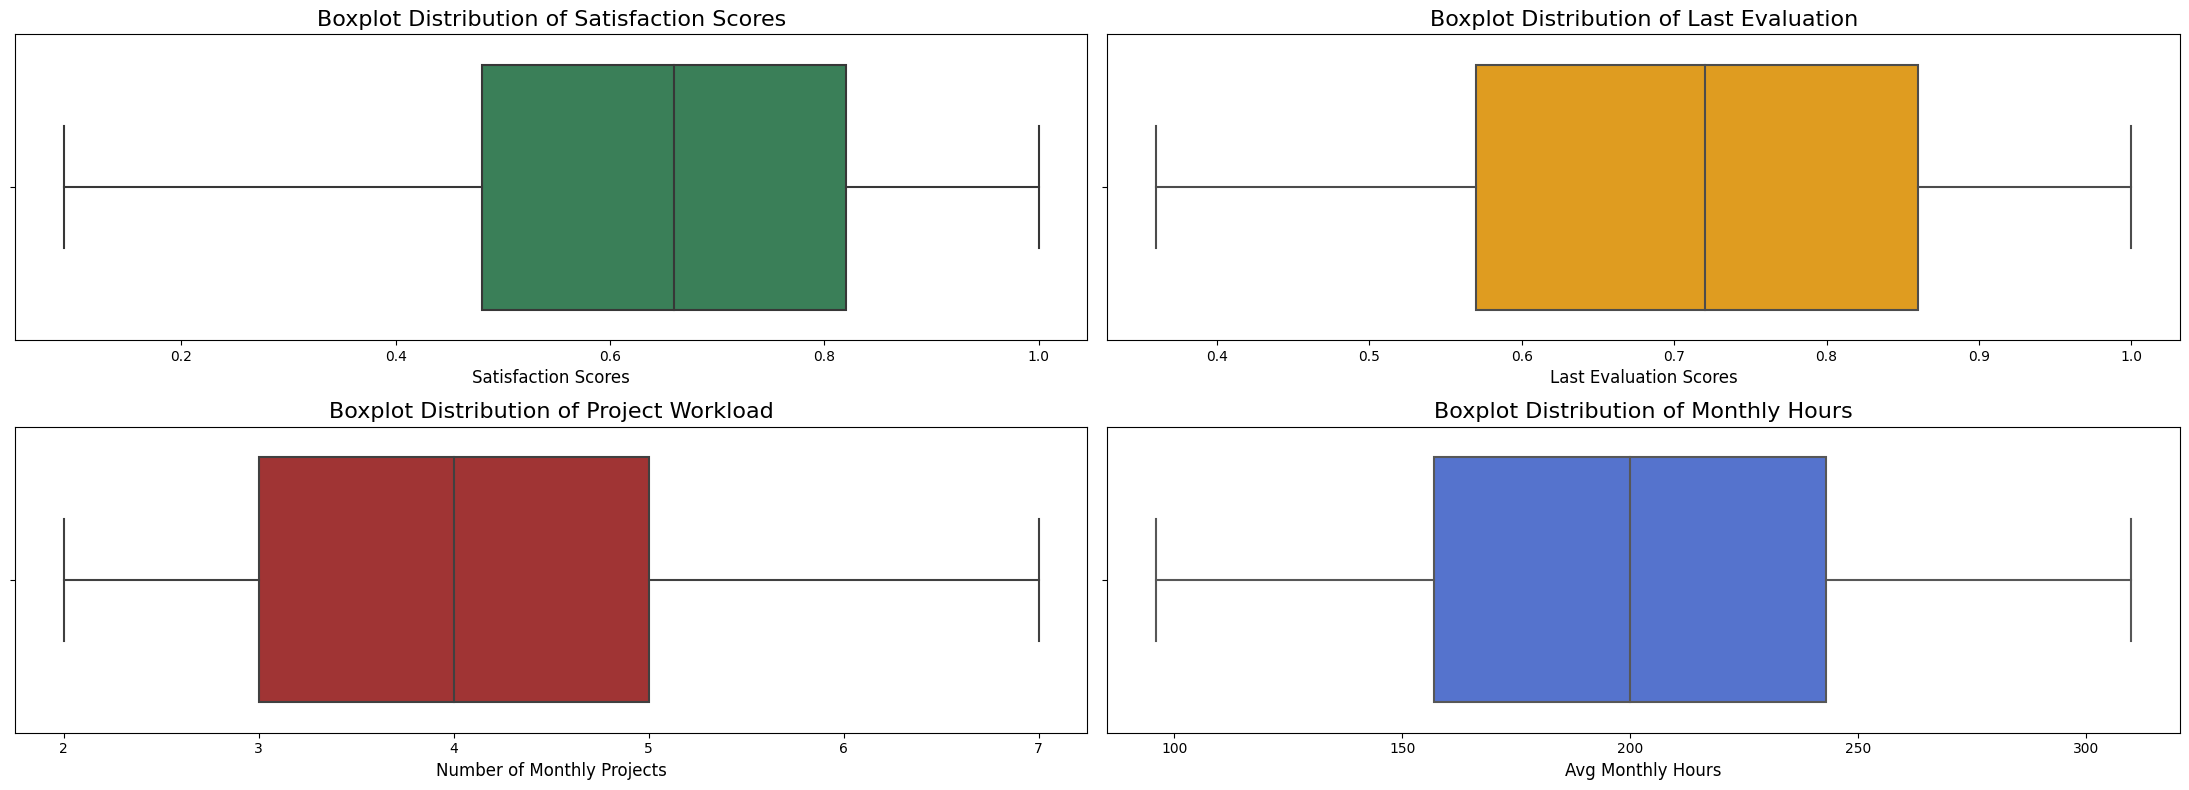

In [157]:
## Set figure and axes
fig, ax = plt.subplots(2, 2, figsize=(22, 8))

# Create a boxplot to visualize distribution of `satisfaction_level` and detect any outliers
sns.boxplot(data=df1, x='satisfaction',fliersize=8, color='seagreen', ax=ax[0,0])
ax[0,0].set_title('Boxplot Distribution of Satisfaction Scores', fontsize=16)
ax[0,0].set_xlabel("Satisfaction Scores", fontsize=12)

# Create a boxplot to visualize distribution of `last_evaluation` and detect any outliers
sns.boxplot(data=df1, x='last_eval',fliersize=8, color='orange', ax=ax[0,1])
ax[0,1].set_title('Boxplot Distribution of Last Evaluation', fontsize=16)
ax[0,1].set_xlabel('Last Evaluation Scores', fontsize=12)

# Create a boxplot to visualize distribution of `number_project` and detect any outliers
sns.boxplot(x=df1['projects'],fliersize=8,color='firebrick', ax=ax[1,0])
ax[1,0].set_title('Boxplot Distribution of Project Workload', fontsize=16)
ax[1,0].set_xlabel("Number of Monthly Projects", fontsize=12)

# Create a boxplot to visualize distribution of `Average monthly hours` and detect any outliers
sns.boxplot(x=df1['avg_hrs_mo'],fliersize=8, color='royalblue', ax=ax[1,1])
ax[1,1].set_title('Boxplot Distribution of Monthly Hours', fontsize=16)
ax[1,1].set_xlabel("Avg Monthly Hours", fontsize=12)

plt.tight_layout()
plt.show()

None of the foregoing features contain outliers. Considering that each of those features describe set ranges, the lack of outliers among them is not surprising.   

For each boxplot, the left-most whisker denotes the threshold for lower-limit outliers, and the right-most whisker denotes the threshold for upper-limit outliers. The left-most border of each box indicates Quantile 1 where 25% of values fall below that line. The dark line that appears in the interior of the individual boxes denotes the median, the mid-point of the data where 50% of the values fall below and above this line. The right-most box border indicates Quantile 3, where 75% of values fall below that line and 25% fall above it. Where there any outliers in any of these features, symbols would appear on the outsides of the whisker lines.

 Aside from `tenure`, the remaining features of the dataset, being binary or categorical, do not have outlier values.

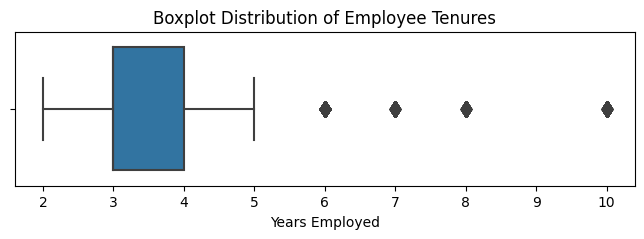

In [158]:
# Create a boxplot to visualize distribution of `tenure` to detect any outliers
plt.figure(figsize=(8,2))
plt.title('Boxplot Distribution of Employee Tenures')
sns.boxplot(x=df1['tenure'],fliersize=8).set(xlabel='Years Employed')

plt.show()

Unlike the previous boxplots, this one shows that the vast majority of employees have been with the organization between 2 and 5 years, with most of those being between 3 and 4 years of service. There are a small number of employees with 6, 7, 8, & 10 years of service. Outliers in such a case, while throwing abnormal values, are legitimate. Unless the business was not in operation 10 years ago, it is reasonable that there would be a handful of "old-timers" at the company.

In [159]:
# Determine the number of rows containing outliers

# Compute the quartile boundaries
df1[df1['tenure'] > 5].shape[0]
percentile25 = df1['tenure'].quantile(0.25)
percentile75 = df1['tenure'].quantile(0.75)

# Calculate the interquartile range (IRQ)
iqr = percentile75 - percentile25

# Calculate the upper and lower thresholds for outliers
upper_limit = percentile75 + (1.5*iqr)
lower_limit = percentile25 - (1.5*iqr)

print(f"Lower Limit: {lower_limit} yrs \nUpper Limit: {upper_limit} yrs \n"\
      f"There are {df1[df1['tenure'] > 5].shape[0]} rows containing outliers in 'tenure'.")

print(f"\nOf the {df1[df1['tenure'] > 5].shape[0]} tenure outliers,\n"\
      f"{df1[(df1['tenure'] > 5) & (df1['termed'] == 1)].shape[0]} have terminated, meaning \n"\
      f"{df1[(df1['tenure'] > 5) & (df1['termed'] == 0)].shape[0]} have stayed with the company.")

Lower Limit: 1.5 yrs 
Upper Limit: 5.5 yrs 
There are 824 rows containing outliers in 'tenure'.

Of the 824 tenure outliers,
109 have terminated, meaning 
715 have stayed with the company.


Certain types of models are more sensitive to outliers than others. When you get to the stage of building your model, consider whether to remove outliers, based on the type of model you decide to use.

## Step 2. Data Exploration (Continue EDA)

Begin by understanding how many employees left and what percentage of all employees this figure represents.

In [160]:
# Get numbers of people who left vs. stayed
print(f"The distribution of {df1.shape[0]} current vs former employees over time, where 0='active' and 1='termed', is:\n" \
      f"{df1['termed'].value_counts()}\n")

# Get percentages of people who left vs. stayed
print(f"The percentage of {df1.shape[0]} current vs former employees over time, where 0='active' and 1='termed', is:\n" \
      f"{df1['termed'].value_counts(normalize=True)*100}\n")

The distribution of 11991 current vs former employees over time, where 0='active' and 1='termed', is:
termed
0    10000
1     1991
Name: count, dtype: int64

The percentage of 11991 current vs former employees over time, where 0='active' and 1='termed', is:
termed
0    83.39588
1    16.60412
Name: proportion, dtype: float64



In [161]:
# Check how many employees have received promotions in the last 5 years
print(f"Out of {df1.shape[0]} total employees, {df1[df1['promo_5yrs'] ==1].shape[0]} have been promoted in the past 5 years.")
print(f"This means that {(df1[df1['promo_5yrs'] ==1].shape[0] / df1.shape[0]*100):.2f}% employees have been promoted in that time.")


Out of 11991 total employees, 203 have been promoted in the past 5 years.
This means that 1.69% employees have been promoted in that time.


### Data visualizations

Now, examine variables that you're interested in, and create plots to visualize relationships between variables in the data.

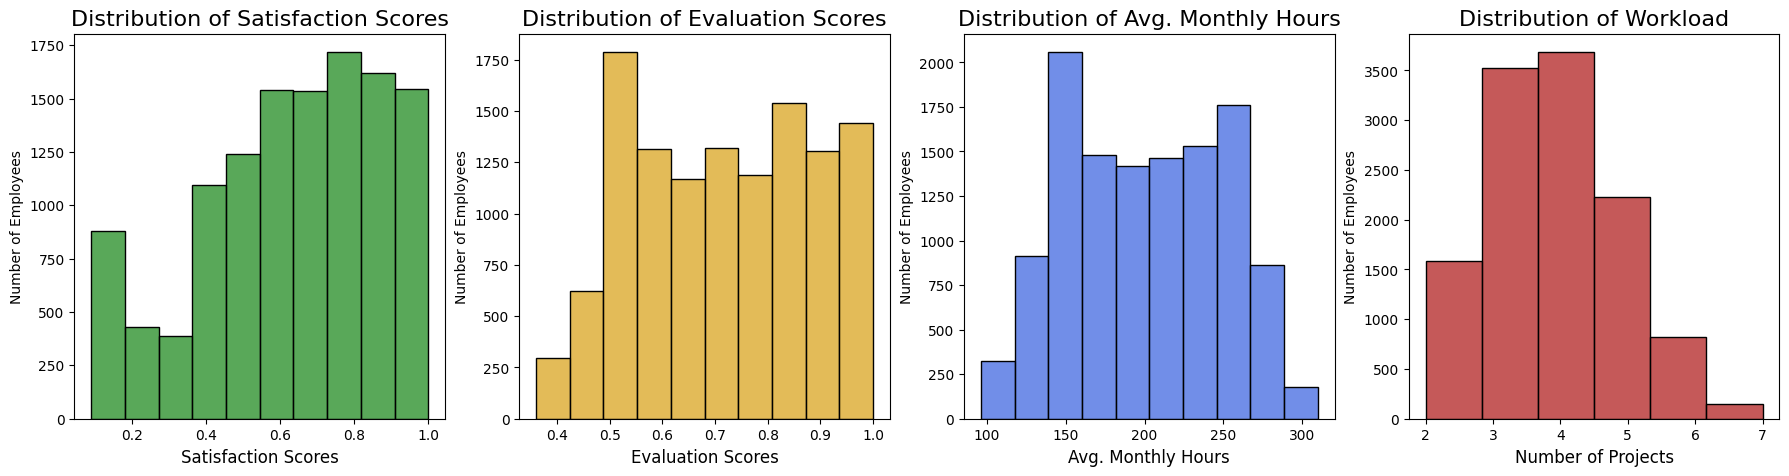

In [162]:
## Set figure and axes
fig, ax = plt.subplots(1, 4, figsize=(22, 5))

# Create a histogram to illustrate distribution of satisfaction levels
sns.histplot(data=df1, x='satisfaction', color='forestgreen', bins=10, ax=ax[0])
ax[0].set_title("Distribution of Satisfaction Scores", fontsize=16)
ax[0].set_xlabel("Satisfaction Scores", fontsize=12)
ax[0].set_ylabel("Number of Employees")

# Create a histogram to illustrate distribution of last evaluation
sns.histplot(data=df1, x='last_eval', color='goldenrod', bins=10, ax=ax[1])
ax[1].set_title("Distribution of Evaluation Scores", fontsize=16)
ax[1].set_xlabel("Evaluation Scores", fontsize=12)
ax[1].set_ylabel("Number of Employees")

# Create a histogram to illustrate distribution of last evaluation
sns.histplot(data=df1, x='avg_hrs_mo', color='royalblue', bins=10, ax=ax[2])
ax[2].set_title("Distribution of Avg. Monthly Hours", fontsize=16)
ax[2].set_xlabel("Avg. Monthly Hours", fontsize=12)
ax[2].set_ylabel("Number of Employees")

# Create a histogram to illustrate distribution of last evaluation
sns.histplot(data=df1, x='projects', color='firebrick', bins=6, ax=ax[3])
ax[3].set_title("Distribution of Workload", fontsize=16)
ax[3].set_xlabel("Number of Projects", fontsize=12)
ax[3].set_ylabel("Number of Employees")

plt.show()

The distribution histograms provide some baseline information about the total employee population to consider:

> **Satisfaction Scores**: These appear to be somewhat fairly distributed with a noticable skew to the left and a large spike at the lowest end. This implies that while the majority of employees reported a positive satisfaction level (above 0.5 for the range), there is some considerable level of dissatisfaction with about 500 employees with the highest dissatisfied scores.

> **Evaluation Scores**: Without a gauge for the ranges, it appears that more employees would fall into either the "Consistently meets expectations" or "Exceeds expectations" if the lower end of that measurement is 0.5 (the boxplot indicates a median of slightly above 0.7), assuming that is the mid-point of the range. Still, there are a considerable number of workers who appear to have less-than average evaluation scores. There seem to be more than about 850 employees with scores below 0.5.

> **Average Monthly Hours**: Workers here put in a lot of hours. Assuming a PTO allowance of 2 weeks per year, the average month of 8-hour days comes to about 166.67 hours. It looks like around 4,500 employees on average work less than a 40-hour week. There are considerably more employees who work more than the monthly average with perhaps around 700 workers putting in close to 300 per month with around 75 or more working more than 300 hours per month. 

> **Number of Projects** These numbers are fairly well normally distributed with some right skew. Most employees averaged 3 to 4 projects per month with 5 projects being a close 3rd. A large number (1,500+) averaged 2 projects, while perhaps around 750 or more worked on 6 projects with a smaller number (perhaps around 100) who worked on 7 projects.

Comparing these total population distributions with the same distributions that parse out active from terminated employees could provide additional insights.

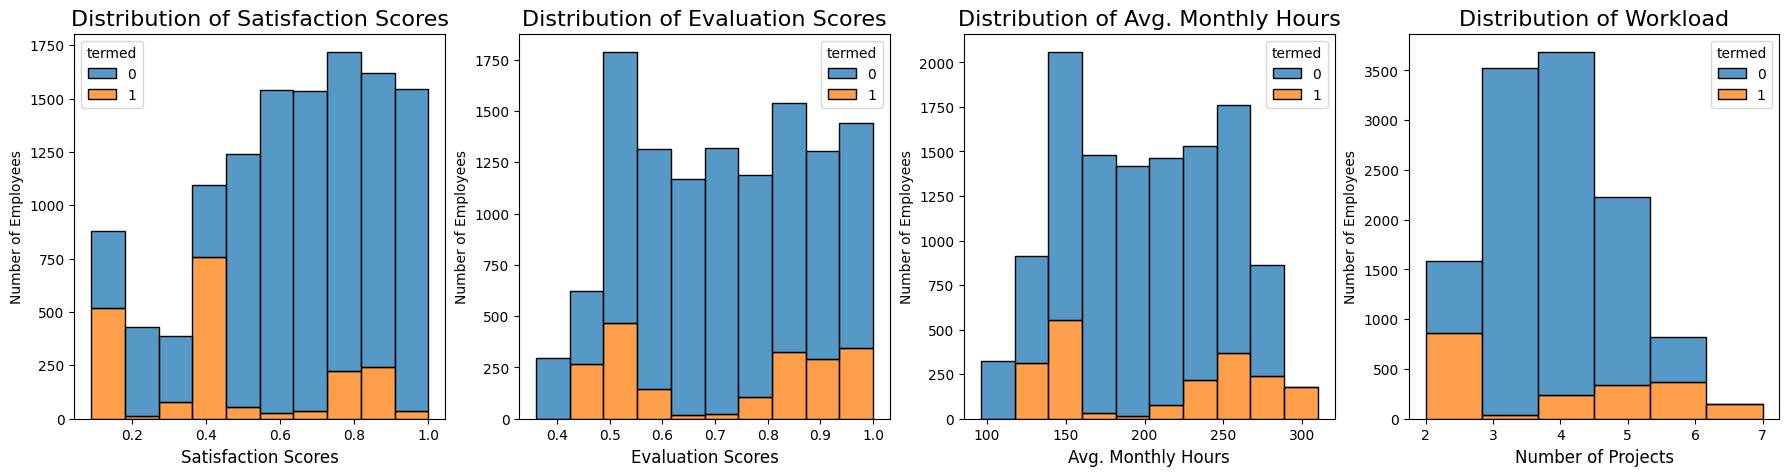

In [163]:
# Set figure and axes
fig, ax = plt.subplots(1, 4, figsize=(22, 5))

# Create a histogram to illustrate distribution of satisfaction levels
tenure_active = df1[df1['termed'] == 0]['projects']
tenure_term   = df1[df1['termed'] == 1]['projects']
sns.histplot(data=df1, x='satisfaction', bins=10, hue='termed', multiple='stack', ax=ax[0])
ax[0].set_title("Distribution of Satisfaction Scores", fontsize=16)
ax[0].set_xlabel("Satisfaction Scores", fontsize=12)
ax[0].set_ylabel("Number of Employees")

# Create a histogram to illustrate distribution of last evaluation
tenure_active = df1[df1['termed'] == 0]['projects']
tenure_term   = df1[df1['termed'] == 1]['projects']
sns.histplot(data=df1, x='last_eval', bins=10, hue='termed', multiple='stack', ax=ax[1])
ax[1].set_title("Distribution of Evaluation Scores", fontsize=16)
ax[1].set_xlabel("Evaluation Scores", fontsize=12)
ax[1].set_ylabel("Number of Employees")

# Create a histogram to illustrate distribution of last evaluation
tenure_active = df1[df1['termed'] == 0]['projects']
tenure_term   = df1[df1['termed'] == 1]['projects']
sns.histplot(data=df1, x='avg_hrs_mo', bins=10, hue='termed', multiple='stack', ax=ax[2])
ax[2].set_title("Distribution of Avg. Monthly Hours", fontsize=16)
ax[2].set_xlabel("Avg. Monthly Hours", fontsize=12)
ax[2].set_ylabel("Number of Employees")

# Create a histogram to illustrate distribution of last evaluation
tenure_active = df1[df1['termed'] == 0]['projects']
tenure_term   = df1[df1['termed'] == 1]['projects']
sns.histplot(data=df1, x='projects', bins=6, hue='termed', multiple='stack', ax=ax[3])
ax[3].set_title("Distribution of Workload", fontsize=16)
ax[3].set_xlabel("Number of Projects", fontsize=12)
ax[3].set_ylabel("Number of Employees")

plt.show()

These visualizations help to understand the dataset in more meaningful ways:

> **Satisfaction Scores**: Slightly less than 2/3 of employees who fall into that 'most-dissatisfied' bin did leave the company with slightly more than 1/3 remained. Few employees left until the scores reach around 0.4 where aroud 750 separated. The majority of the reamining scores are from employees who remain with the company, except for a small peak between 0.8 to 0.9 where around 450 employees left. The number of employees who have stayed remains considerably higher than those that have left. **Note**: Employee Satisfaction Scores are the result of a self-reported survey. This type of data collection is inherently unreliable because the expectation of honesty in the answers is complicated by concerns about confidentiality, or about or for one's manager, etc. Higher scores tend to be inflated, while lower scores could be conservative, or the result of malice.

> **Evaluation Scores**: Poor evaluation scores do not seem to be very highly correlated with leaving. The lowest scores seem not to have triggered departures. There is a small peak between about 0.45 and 0.65 and another from above 0.8 to 1.0 Considerably more employees stayed than left, and the proportions between the two subsets seems to reflect expected turnover.

> **Average Monthly Hours**: These divisions are strikingly similar to those for Evaluation Scores, the difference being that it appears that everyone who worked around 300 hours left the company. About 750 or more employees working under the monthly average number of work hours departed. 

> **Number of Projects**: More workers with just 2 projects left the company than stayed, while it seems every employee working on 7 average projects per month left. Almost half of the workers with 6 average projects per month terminated as well.

In [164]:
# Validate the value counts for the employees who had 7 projects
df1[df1['projects'] == 7]['termed'].value_counts()

termed
1    145
Name: count, dtype: int64

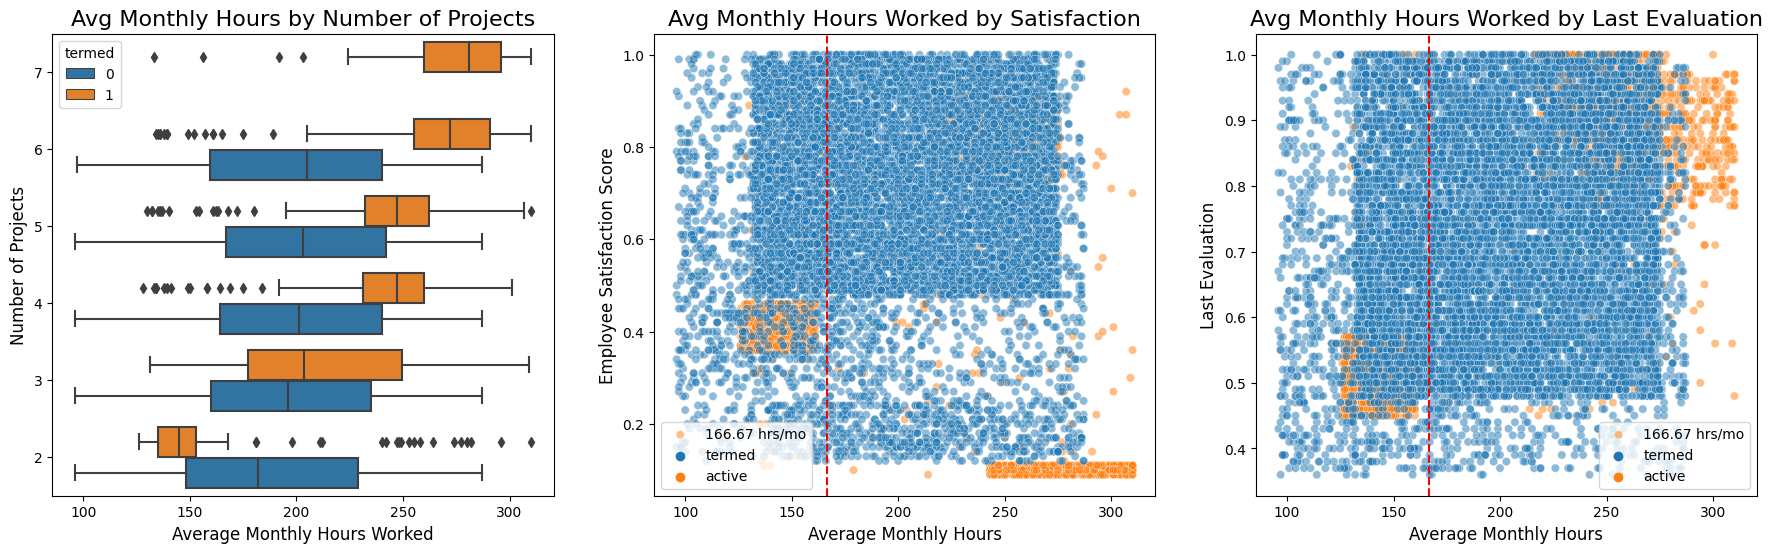

In [165]:
# Set figure and axes
fig, ax = plt.subplots(1, 3, figsize=(22, 6))

# Generate a box plot showing active & termed groups by avg # hrs/mo by # projects
sns.boxplot(data=df1, x='avg_hrs_mo', y='projects', hue='termed', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Avg Monthly Hours by Number of Projects', fontsize=16)
ax[0].set_xlabel("Average Monthly Hours Worked", fontsize=12)
ax[0].set_ylabel("Number of Projects", fontsize=12)

# Generate a scatterplot of average hours worked by satisfaction score showing active vs termed
sns.scatterplot(data=df1, x='avg_hrs_mo', y='satisfaction', hue='termed', alpha=0.5, ax=ax[1])
ax[1].set_title("Avg Monthly Hours Worked by Satisfaction", fontsize=16)
ax[1].axvline(x=166.7, color='red', label='Std. 166.67 hrs/mo', ls='--')
ax[1].legend(labels=['166.67 hrs/mo', 'termed', 'active'])
ax[1].set_xlabel("Average Monthly Hours", fontsize=12)
ax[1].set_ylabel("Employee Satisfaction Score", fontsize=12)

# Generate a scatterplot of average hours worked by last evaluation showing active vs termed
sns.scatterplot(data=df1, x='avg_hrs_mo', y='last_eval', hue='termed', alpha=0.5, ax=ax[2])
ax[2].set_title("Avg Monthly Hours Worked by Last Evaluation", fontsize=16)
ax[2].axvline(x=166.7, color='red', label='Std. 166.67 hrs/mo', ls='--')
ax[2].legend(labels=['166.67 hrs/mo', 'termed', 'active'])
ax[2].set_xlabel("Average Monthly Hours", fontsize=12)
ax[2].set_ylabel("Last Evaluation", fontsize=12)
plt.show()

These plots are quite interesting. It seems reasonable that, with more projects to work, more hours would be put in. However, the boxplot shows that, for employees who remain with the company, the range of hours worked remains close to the same regardless of the number of projects. It appears to be the employees who left who increased their average monthyly work hours as their nubmer of projects increased. Also, there are outliers in the numbers of hours worked only for those employees who left, except for those working 3 projects, although they did worked on average more hours than those employees with 3 projects who stayed. All of the employees (and only the employees) who worked on 7 projects worked the most number of hours and left the company. The interquartile ranges for termed employees with 6 and 7 projects was from about 255 to 295 hours per month, far more hours than any other group.

The first scatterplot indicates a sizeable group of workers who put in on average ~240-320 hours per month, at least 17.5 hours of overtime per week. If the majority of those employees are non-exempt it would seem prohibitively expensive. If the majority of them are exempt, then it is no surprise that their satisfaction scores are close to zero and they left the company. There's another group of former employees who worked fewer than the monthly average hours with a satifaction score around 0.4. There is one last group of departed employees who had satifactions levels between about 0.7 and 0.9 who worked an average of between ~220-280 hours.

The second scatterplot shows two groups of employees who left the company: one that worked below the average number of hours and had lower evaluation scores; and one that had satisfaction scores around 0.8 to about 0.95 and worked in excess of ~225 hours per month on average. It also shows that most employees work more than 167 hours per month.

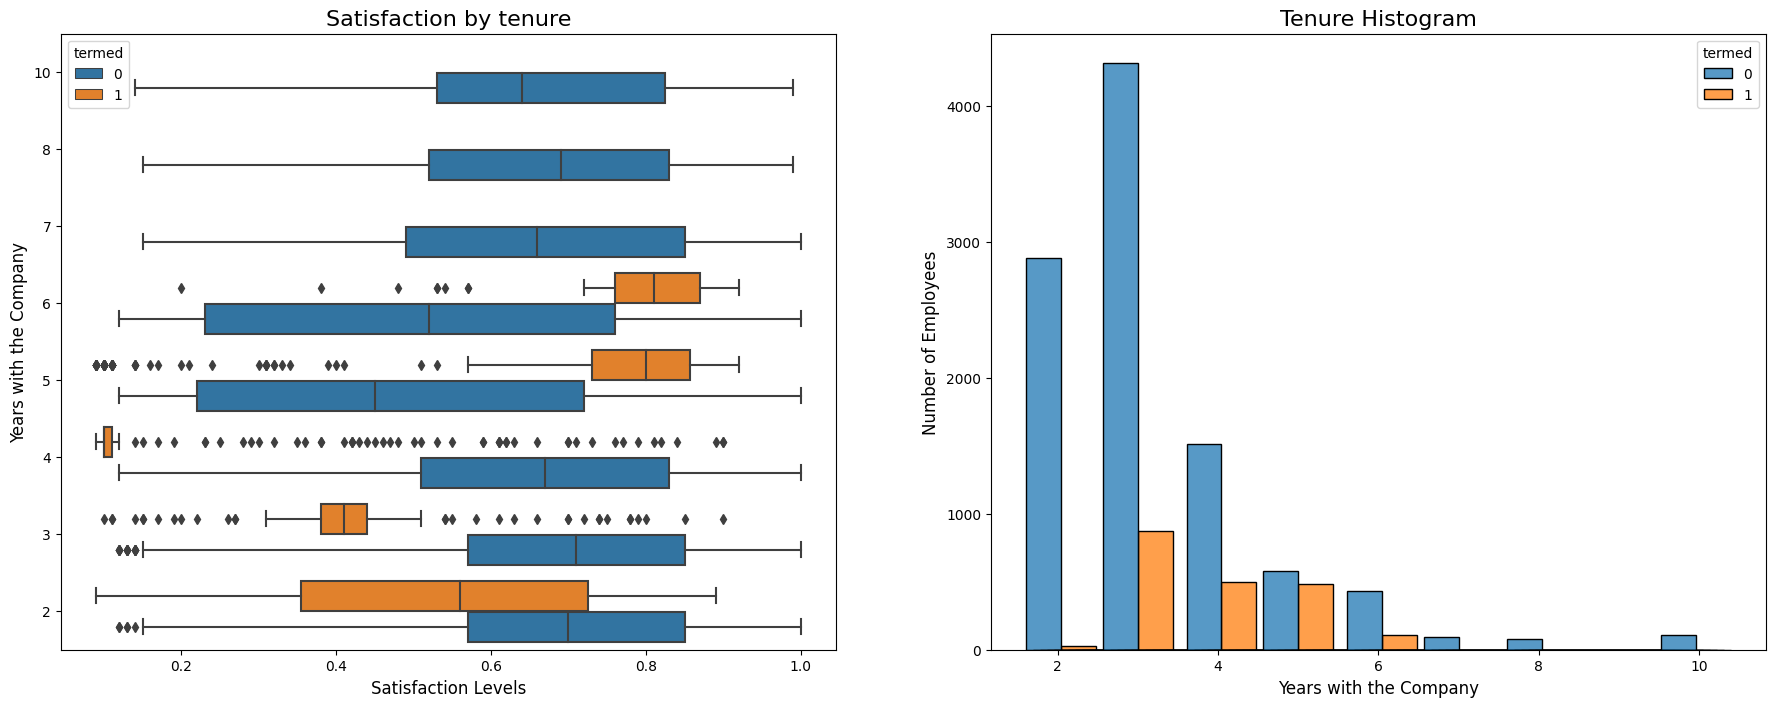

In [166]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction', y='tenure', hue='termed', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize=16)
ax[0].set_xlabel("Satisfaction Levels", fontsize=12)
ax[0].set_ylabel("Years with the Company", fontsize=12)

# Generate a histogram showing distribution of projects among the active and termed groups
tenure_active = df1[df1['termed'] == 0]['projects']
tenure_term   = df1[df1['termed'] == 1]['projects']
sns.histplot(data=df1, x='tenure', hue='termed', multiple='dodge', shrink=10, ax=ax[1])
ax[1].set_title("Tenure Histogram", fontsize=16)
ax[1].set_xlabel("Years with the Company", fontsize=12)
ax[1].set_ylabel("Number of Employees", fontsize=12)

plt.show()

These plots offer the several observations:  
- Former workers fall into two groups: dissatisfied employees with short tenure with the company, and medium-term moderately satisfied employees. 
- The employees with the longest tenures have all stayed, and their satisfaction levels approximates those of the newest employees.
- The employees who left at 4 years had the lowest satisfaction score as a group with plenty of outliers along the spectrum.
- The histogram shows that there are significantly fewer employees with 7 years or more tenure, and none of those employees have left. The majority of employees have been with the company between 2 and 4 years, with the highest number around year 3.

Let's explore how salaries and tenure distribute.

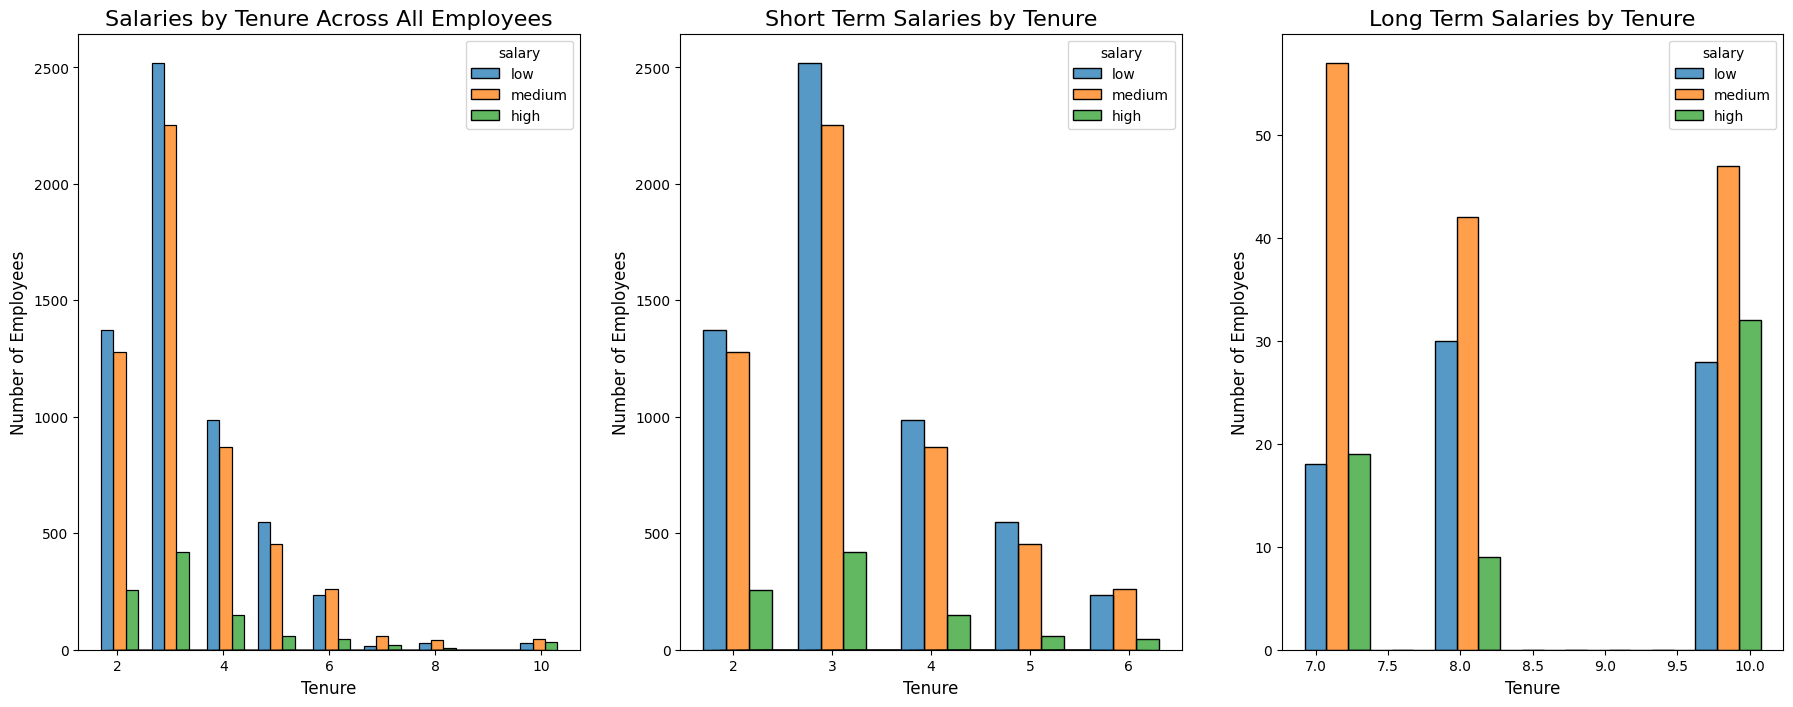

In [167]:
## Set figure and axes
fig,ax = plt.subplots(1,3, figsize=(22, 8))

# Create subgroups for tenure
tenure_long  = df1[df1['tenure'] > 6]
tenure_short = df1[df1['tenure'] < 7]
hue_order = ['low', 'medium', 'high']

# First, plot all employees by tenure by salary
sns.histplot(data=df1, x = 'tenure', hue='salary', hue_order=hue_order, multiple='dodge', shrink=8, ax=ax[0])
ax[0].set_title("Salaries by Tenure Across All Employees", fontsize=16)
ax[0].set_xlabel("Tenure", fontsize=12)
ax[0].set_ylabel("Number of Employees", fontsize=12)

# Second, plot the short-term employees by tenure by salary
sns.histplot(data=tenure_short, x='tenure', hue='salary', hue_order=hue_order, multiple='dodge', shrink=8, ax=ax[1])
ax[1].set_title("Short Term Salaries by Tenure", fontsize=16)
ax[1].set_xlabel("Tenure", fontsize=12)
ax[1].set_ylabel("Number of Employees", fontsize=12)

# Third, plot the long-term employees by tenure by salary
sns.histplot(data=tenure_long, x='tenure', hue='salary', hue_order=hue_order, multiple='dodge', shrink=1.5, ax=ax[2])
ax[2].set_title("Long Term Salaries by Tenure", fontsize=16)
ax[2].set_xlabel("Tenure", fontsize=12)
ax[2].set_ylabel("Number of Employees", fontsize=12)

plt.show()

This plot indicates that employee salaries across the board are in the main medium to low. Even long-term employees are not overwhelmingly high salaried; the majority of employees iwth more than 7 years seniority are medium salaried. Most employees in the short-term tenure cohort are low salaried, but not by much overall. The number of medium-salaried workers overtakes low-salaried workers at year six. The greatest number of high salaried employees have a tenure of 10 years. 

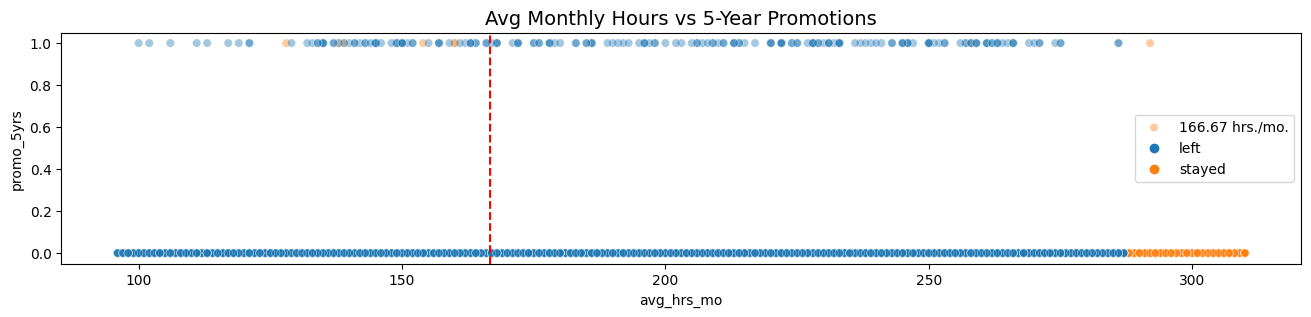

In [168]:
# Create plot to illustrate the relationship between hours worked and promotions
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='avg_hrs_mo', y='promo_5yrs', hue='termed', alpha=0.4)
plt.axvline(x=166.67, color='red', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Avg Monthly Hours vs 5-Year Promotions', fontsize='14');

The majority of employees have tenure of 4 years or less, so this plot is less surprising on reflection than at first glance. 

Let's see how employees distribute across the company departments.

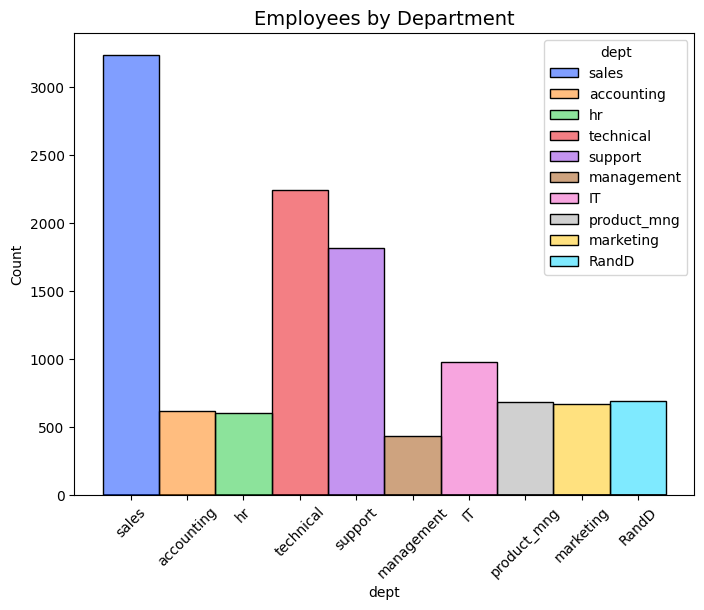

In [169]:
# Plot a histogram of employees across departments
plt.figure(figsize=(8,6))
sns.histplot(data=df1, x='dept', bins=10, hue='dept', palette=sns.color_palette("bright"), discrete=1)
plt.xticks(rotation=45)
plt.title('Employees by Department', fontsize=14)
plt.show()

The most employees are in the `sales` department, followed by `technical` and `support`. There are under 500 employees in `management`. All other departments have similar total number of employees. These figures include terminated employees. It should be noted that for HR purposes, "terminated" simply means that a person has left the company; no distinction is made to the quality of the departure. Other terms, such as volunatary or involunatary termination are used internally.

Next, let's separate the active from the inactive/terminated employees to see what the population as it currently is structured.

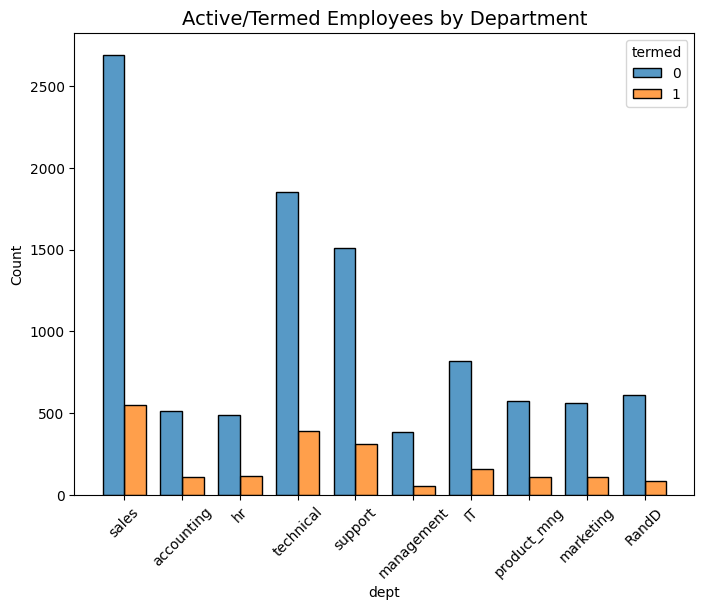

In [170]:
# Next, a histogram of subsetted active/termed employees across departments
plt.figure(figsize=(8,6))
sns.histplot(data=df1, x='dept', hue='termed', discrete=1,hue_order=[0, 1], shrink=.75, multiple='dodge')
plt.xticks(rotation=45)
plt.title('Active/Termed Employees by Department', fontsize=14);

The most employees are in the `Sales` department which also has the highest separation rate. The next most populated departments are `Technical` followed by `Support`, both of which also place 2nd and 3rd in the number of employees who left. The department with the fewest number of current employees and departures is `Management`.

In [171]:
# Calculate the mean and median satisfaction levels for active and termed employees
df1.groupby(['termed'])['satisfaction'].agg([np.mean, np.median])

mean  median
termed                  
0       0.667365    0.69
1       0.440271    0.41

Plot a heatmap to give visualization to any correlations among the features of the dataset.

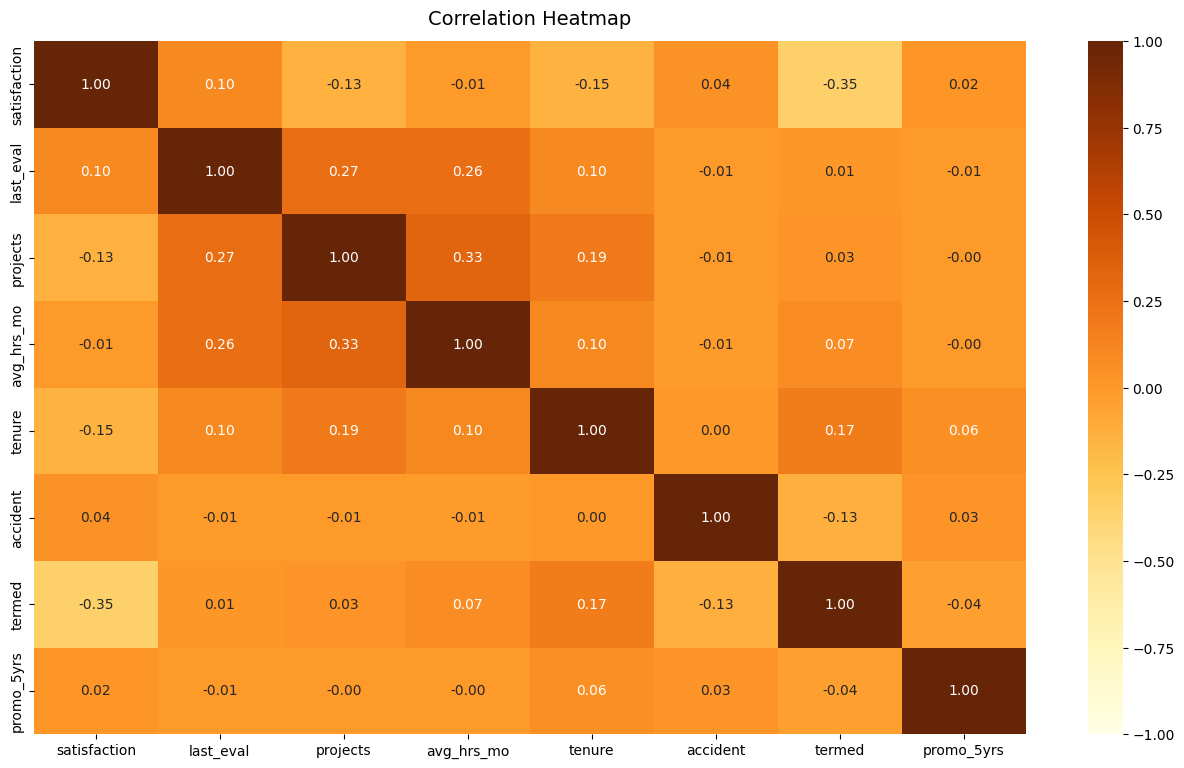

In [172]:
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df1.drop(['dept','salary'], axis=1).corr(), vmin=-1, vmax=1, 
                      annot=True, fmt='.2f', cmap=sns.color_palette("YlOrBr", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

The correlation heatmap validates that the number of projects, average monthly hours, and last evaluation score all have some positive correlation with each other. There is a negative correlation between employees who left and their employee satisfaction sccores.

### Insights

It appears that employees tend to leave the company who have high numbers of average monthly work hours, and more than 4 projects per month. The satisfaction scores may be associated with departures, but due to the subjective nature of the data (self-reported under unknown conditions), they tend to be less reliable than objective data. These observations could be the result of poor management and workload misalignment. Five years is a long time to go without a promotion and there seem to be comparably few of them. Working long hours on too many projects with a distant hope of promotion leads to low morale. Resulting behavior issues, burn-out, and job dissatisfaction are the likely reasons for turnover. Employees who make it to their 6th year with the company tend not to leave.

## Step 3. Model Building
- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model

### Identify the type of prediction task.

The goal is to predict whether an employee will leave the company or not, which is a binary categorical outcome. There are two possible (binary) outcomes: the employee leaves (1) or they don't (0). The outcome may be influenced by any of a number of independent variables in the dataset. 

### Identify the types of models most appropriate for this task.

The target variable, `termed`, is categorical. This task could be approached with a **binomial logistic regression** or a **tree-based Machine Learning model**. In order to be thorough, and to attempt to find the best model, both approaches will be attempted.

## Model 1: Binomial Logistic Regression

First, we'll make a copy of the cleaned dataset to work on, and then split the data into train and test sets. There are two non-numeric variables, `dept` and `salary` that need to be encoded.  

The `dept` variable is categorical and should be dummy encoded. Because we need all of the departments, the first value should not be dropped. 

`salary` is also categorical but is also has a specific order (ordinal). The values will be converted as `low` = 0, `medium` = 1, `high` = 2. 

We'll name this copy `df_encoded`.

In [173]:
# First, make a copy of the dataframe
df_encoded = df1.copy()

# We have to encode `salary` next because the get_dummy() function for `dept` will also catch `salary` if not preprocessed.
df_encoded.salary = df_encoded.salary.astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes


# Now `dept` can be encoded
df_encoded = pd.get_dummies(df_encoded, drop_first=False)

# Inspect the results.
df_encoded.head()


satisfaction  last_eval  projects  avg_hrs_mo  tenure  accident  termed  \
0          0.38       0.53         2         157       3         0       1   
1          0.80       0.86         5         262       6         0       1   
2          0.11       0.88         7         272       4         0       1   
3          0.72       0.87         5         223       5         0       1   
4          0.37       0.52         2         159       3         0       1   

   promo_5yrs  salary  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0           0       0    False       False            False    False   
1           0       1    False       False            False    False   
2           0       1    False       False            False    False   
3           0       0    False       False            False    False   
4           0       0    False       False            False    False   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0            False           False             False        True   
1            False           False             False        True   
2            False           False             False        True   
3            False           False             False        True   
4            False           False             False        True   

   dept_support  dept_technical  
0         False           False  
1         False           False  
2         False           False  
3         False           False  
4         False           False

The goal is to predict whether employees will leave or not. Recall that in the `tenure` variable, it was observed that employees with 7 or more years of service tend not to leave; there are no `termed` employees in that subgroup. For a prediction model, those employees would be considered outliers. Logistic Regression models are particularly susceptible to outliers so those employees should be isolated from the model dataframe.

In [176]:
# Display the number of active and inactive employees before separating out the `tenure` outliers. 
print(f"Number of Active and Termed Employees: \n{df_encoded['termed'].value_counts()}\n")
print(f"Proportion of Active vs Termed Employees: \n{df_encoded['termed'].value_counts(normalize=True)*100}")

Number of Active and Termed Employees: 
termed
0    10000
1     1991
Name: count, dtype: int64

Proportion of Active vs Termed Employees: 
termed
0    83.39588
1    16.60412
Name: proportion, dtype: float64


In [177]:
# Select out the outliers from `tenure` to a new working dataframe
df_logreg = df_encoded[(df_encoded['tenure'] >= lower_limit) & (df_encoded['tenure'] <= upper_limit)]

# Inspect the new dataframe
df_logreg.head()

satisfaction  last_eval  projects  avg_hrs_mo  tenure  accident  termed  \
0          0.38       0.53         2         157       3         0       1   
2          0.11       0.88         7         272       4         0       1   
3          0.72       0.87         5         223       5         0       1   
4          0.37       0.52         2         159       3         0       1   
5          0.41       0.50         2         153       3         0       1   

   promo_5yrs  salary  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0           0       0    False       False            False    False   
2           0       1    False       False            False    False   
3           0       0    False       False            False    False   
4           0       0    False       False            False    False   
5           0       0    False       False            False    False   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0            False           False             False        True   
2            False           False             False        True   
3            False           False             False        True   
4            False           False             False        True   
5            False           False             False        True   

   dept_support  dept_technical  
0         False           False  
2         False           False  
3         False           False  
4         False           False  
5         False           False

In [179]:
# Display the number of active and inactive employees after separating out the `tenure` outliers. 
print(f"Number of Active and Termed Employees: \n{df_logreg['termed'].value_counts()}\n")
print(f"Proportion of Active vs Termed Employees: \n{df_logreg['termed'].value_counts(normalize=True)*100}")

Number of Active and Termed Employees: 
termed
0    9285
1    1882
Name: count, dtype: int64

Proportion of Active vs Termed Employees: 
termed
0    83.146772
1    16.853228
Name: proportion, dtype: float64


With the outliers removed, the class imbalance between termed and active employees increased slightly by about $0.25\%$. Because the `termned` feature will be our target (outcome, what we're trying to predict) variable during modeling, this imbalance should be retained using the `stratify=y` argument when splitting the dataset into train and test sets.

In [180]:
# Isolate the target
y = df_logreg['termed']

# Isolate the predictor features
X = df_logreg.copy().drop(['termed'], axis=1)

# Built the train and test sets, being sure to stratify the target.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=415)

Construct the logistic regression model and fit it to the training dataset.

In [198]:
# Instantiate the logistic regression model, then fit the model to the training data
logreg_clf = LogisticRegression(random_state=415, verbose=1, max_iter=500)
logreg_clf.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=415, verbose=1)

Now test the model's prediction performance using the test data.

In [199]:
# Get the predictions
logreg_preds = logreg_clf.predict(X_test)

There are a number of metrics that we can retrieve from the model: 

In [200]:
# Retrieve the evaluation metrics
logreg_coef = logreg_clf.coef_
logreg_intercept = logreg_clf.intercept_
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_test, logreg_preds)
logreg_roc_auc = roc_auc_score(y_test, logreg_preds)
logreg_f1 = f1_score(y_test, logreg_preds)
logreg_precision = precision_score(y_test, logreg_preds)
logreg_recall = recall_score(y_test, logreg_preds)
logreg_accuracy = accuracy_score(y_test, logreg_preds)


The master results table will include the scores: **F1**, **Precision**, **Recall**, **Accuracy**, and **ROC_AUC**. We should have a look at the regression's coefficient and intercept scores.

In [206]:
# Print the LR coefficient (slope) and intercept scores:
print(f"The Beta Coefficient (slope) for the logistic regression model is:\n {logreg_coef}" \
      f"\nThe Intercept value for the logistic regression model is:\n{logreg_intercept}")

The Beta Coefficient (slope) for the logistic regression model is:
 [[-4.32874516e+00  1.21388286e-01 -4.65979908e-01  3.91654432e-03
   1.01240286e+00 -1.48472349e+00 -6.41347125e-01 -4.35019854e-01
  -1.17928858e-01 -4.29597787e-01 -1.65855018e-01  2.29169439e-03
  -3.30775866e-01 -5.69244582e-02 -7.92910066e-02  3.87826721e-02
   1.61378032e-02  2.37804573e-02]]
The Intercept value for the logistic regression model is:
[-1.31875525]


#### Create a ROC curve
To assess how well the logistic regression model performed, the ROC curve can visualize the model's *sensitivity* - the model's probability to predict a positive outcome when the outcome is actually positive - and *specificity* - the model's probability to accurately predict actual negative outcomes. The ROC Curve's plotted line indicates how well the does at classifying the data into categories and delineates the "area under the curve". The closer the AUC is to 1, the better the model performs. An AUC of 0.5 would mean that the model fares no better than a random guess. An ideal model will have a plot line that closely hugs the upper left corner of the plot area.

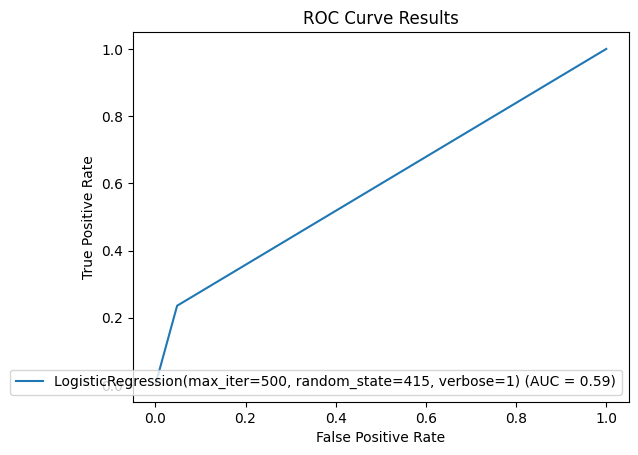

In [207]:
display = RocCurveDisplay(fpr=logreg_fpr, tpr=logreg_tpr, roc_auc=logreg_roc_auc, estimator_name=logreg_clf)
display.plot()
plt.title("ROC Curve Results")
plt.show()

Our logistic regression model has an `AUC` of about $0.60$, meaning that this model performs only slightly better than random guesses. 

Create a confusion matrix to better visualize the results and performance of the model. The blocks of a confusion matrix show, starting from the upper left and going clockwise: **True Positives**, **False Negatives**, **True Negatives**, and **False Positives**. A perfect model will have no false positives or false negatives. Easier said than done. 

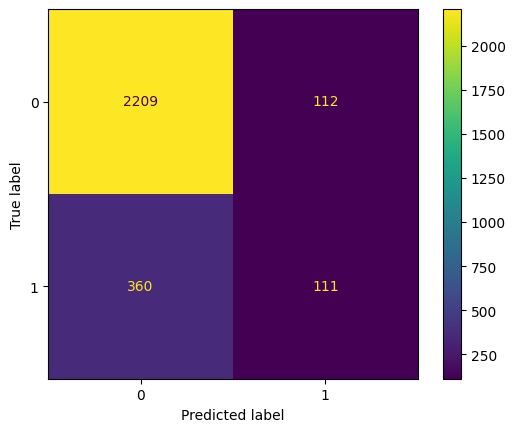

In [209]:
logreg_cm = confusion_matrix(y_test, logreg_preds, labels=logreg_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=logreg_cm, display_labels=logreg_clf.classes_)
disp.plot(values_format='');

The confusion matrix confirms that the logistic regression model does not perform particularly well. While a good number of true negatives (employees who did not leave) were predicted, the number of true positives (111) predicted is a mere fraction of the predicted true negatives (2,209). That might be reasonable if the false negatives (360) and false positives (112) were in single digits. But they're not and this model falsely predicts more people will not leave than actually did, and that more people would stay who actually left. 

We'll display a classification report of the main classification metrics and save the results to a dataframe table to compare results of all the models we end up building.

In [210]:
# Create a classification report from the model
result_names = ['Predicted to Stay', 'Predicted to Leave']
logreg_class_rpt = classification_report(y_test, logreg_preds, target_names=result_names)
print(logreg_class_rpt)

                    precision    recall  f1-score   support

 Predicted to Stay       0.86      0.95      0.90      2321
Predicted to Leave       0.50      0.24      0.32       471

          accuracy                           0.83      2792
         macro avg       0.68      0.59      0.61      2792
      weighted avg       0.80      0.83      0.81      2792



As the confusion matrix predicted, the logistic regression model performed well when predicting employees who would stay, but performed poorly predicting employees who left. In the 2nd group of figures, the weighted averages are the key overall metrics.

We'll store the model results in a dataframe to monitor the progress.

In [211]:
# Make a dataframe of the results of the logistic regression model
master_results = pd.DataFrame({'model_name': 'Logistic Regression',
                               'f1' : [logreg_f1],
                               'precision' : [logreg_precision],
                               'recall' : [logreg_recall],
                               'accuracy' : [logreg_accuracy],
                               'roc_auc' : [logreg_roc_auc]})
master_results

model_name        f1  precision    recall  accuracy   roc_auc
0  Logistic Regression  0.319885   0.497758  0.235669  0.830946  0.593707

## Model 2: Tree-Based Modeling

First, we'll build a `DecisionTreeClassifier` model. While very prone to high variance overfitting or high bias underfitting, it is usually a good place to start because it requires so little, if any, preprocessing. And since one tree is seldom enough, we'll also model a `RandomForestClassifier` to build a whole bunch of trees. 

For both models, we'll build a preliminary model with `GridSearchCV` to obtain the best model parameters, then we'll retrain the model with those parameters. Lastly, we'll fit the models to the test data to get the final results.

From there, we'll do some additional feature engineering to see if we can improve the models, and we'll do it all again in Round 2 with reconfigured sets of train and test data.

We'll start by creating that separate training and testing dataset.

In [159]:
# Create new train and test datasets for this approach.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=440)

### Decision Tree (Round 1)
A decision tree can be used for predicting categorical or continuous variables. In this case, we're looking at the `termed` variable as our target/outcome feature (did the employee leave or not), so we need to use the `DecisionTreeClassifier` model. 

The structure of decision tree is simple - it hierarchically splits data down into subsets which are then split again into the smaller partitions or branches until they become “pure”, meaning the features inside the branch all belong to the same class. Such an endpoint is called a "leaf," which represents the outcome. The biggest advantage to a decision tree is that they make it very easy to visualize nonlinear data patterns. They are fast and, on smaller datasets, can be reasonably accurate. 

In [212]:
# Instantiate the model
tree = DecisionTreeClassifier(random_state=440)

# Assign the tuning hyperparameters
cv_params = {'max_depth' : [4, 5, 6, 8, None],
             'min_samples_leaf' : [1, 2, 5],
             'min_samples_split': [2, 4, 6]}
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate the gridsearch
tree_cv = GridSearchCV(tree, cv_params, scoring=scoring, cv=5, verbose=1, refit='roc_auc')

In [213]:
%%time

# Fit the model
tree_cv.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
CPU times: total: 4.33 s
Wall time: 5.65 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=440),
             param_grid={'max_depth': [4, 5, 6, 8, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [217]:
# Display the best estimator values
tree_cv.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, random_state=440)

In [218]:
# Display the best parameters
tree_cv.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

We will rerun the model with these best parameters, but let's see how well the first run did.

In [219]:
tree_cv.best_score_

0.974172898464111

This is a good AUC score, indicating that this model will predict employees who leave very well. Re-run the model with the updated parameters

In [220]:
%%time
tree2 = DecisionTreeClassifier(random_state=440)

# Assign the tuning hyperparameters
cv_params = {'max_depth' : [4],
             'min_samples_leaf' : [5],
             'min_samples_split': [2]}
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate the gridsearch
tree_eval = GridSearchCV(tree2, cv_params, scoring=scoring, cv=5, verbose=1, refit='roc_auc')
tree_eval.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 62.5 ms
Wall time: 116 ms


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=440),
             param_grid={'max_depth': [4], 'min_samples_leaf': [5],
                         'min_samples_split': [2]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [221]:
tree_eval.best_score_

0.974172898464111

Lovely. The model as built returns the same best score value the best score from best estimator discovered in the first run.

We'll plot the decision tree to see how things broke out. At each decision node, the child node to the left reflects a true decision at the parent node, while the child node on the right is a negative decision. Each node is a decision point until a final leaf is met.

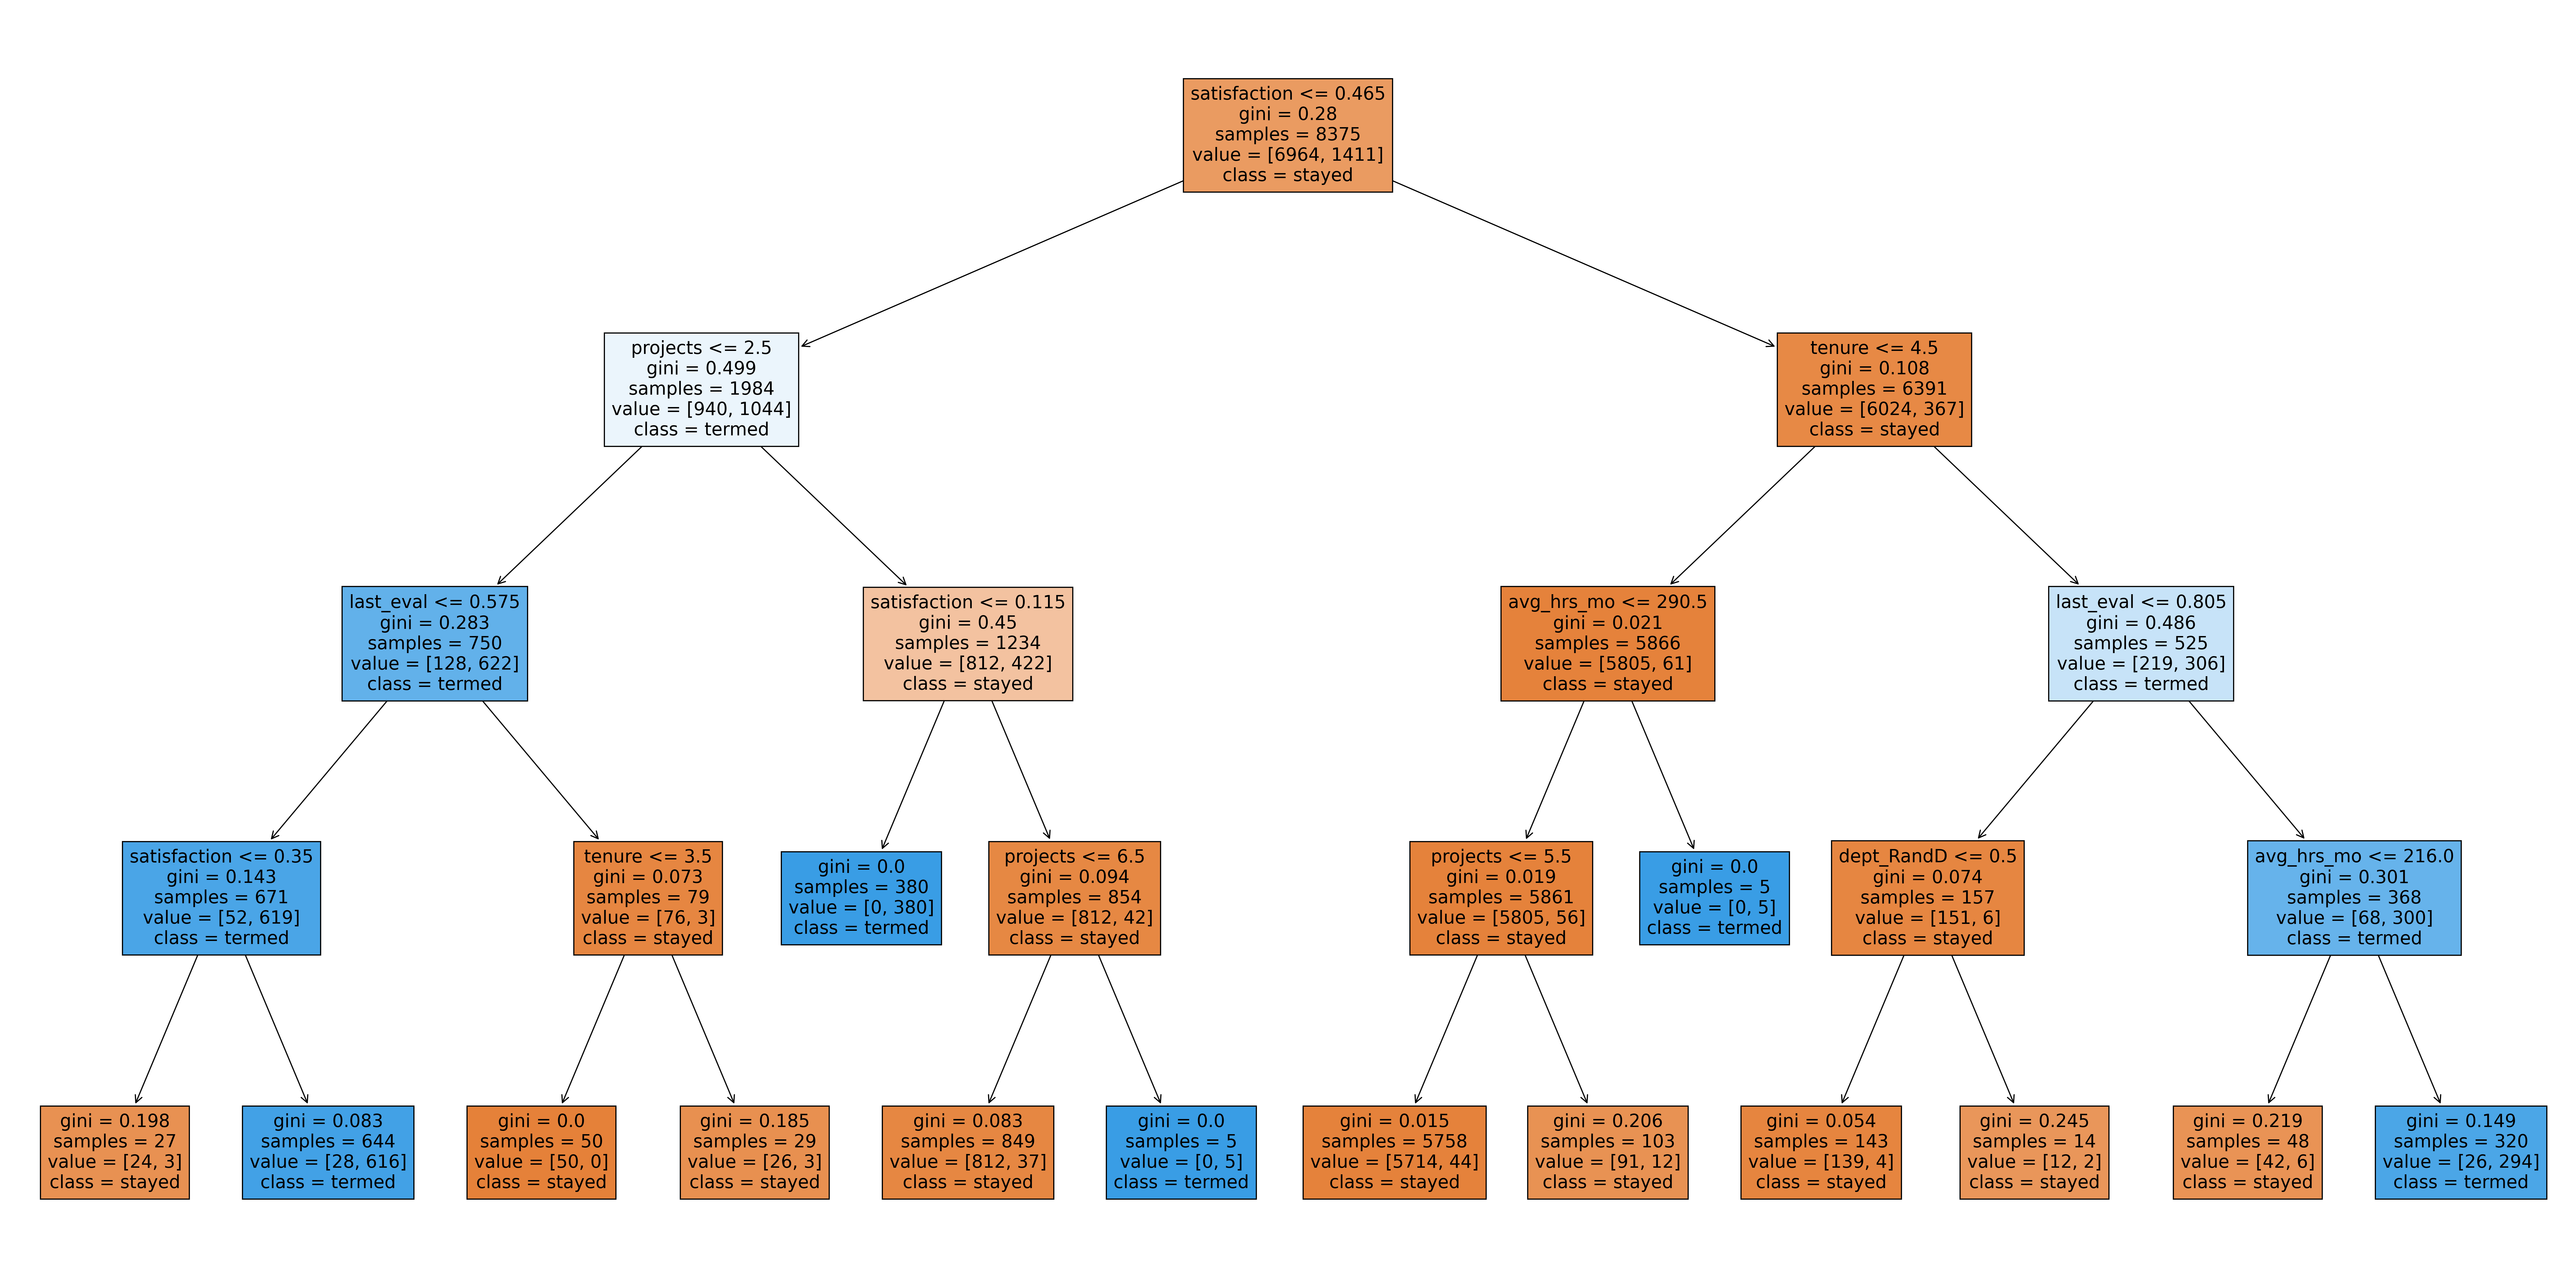

In [224]:
# Plot the best tree
plt.figure(figsize=(40,20), dpi=300)
plot_tree(tree_eval.best_estimator_, feature_names=(list(X.columns)), class_names=(['stayed', 'termed']), 
          filled=True);

We've got a few actual leaves in this model starting on the 3rd level. The nodes with a `gini` value of 0.0 indicate nodes that are pure for the listed class -- that is, that there are no members of any other class in the node. A `gini` score of 0.5 indicates that all classes are equally represented in the node.

The node on third level below the root, the blue 3rd node from the left shows a `gini` of 0.0. There are 380 samples from the previous decision, and all of those 380 employees left. For those, we can say that they had an `satisfaction` level less than or equal to 0.115 (11.5\%), and worked on 2.5 or fewer `projects`. Likewise, an additional tranche of five employees with a `satisfaction` level of 0.115 or less, and who worked on 6.5 or fewer `projects` left the company. On the other side of the tree, five employees with 4.5 years' `tenure`, and working 290.5 or fewer `avg_hrs_mo` also left the company. 

We can also validate a trend that was noticable in the EDA visualizations: that more employees who work on 2.5 projects or less come to a termination point in fewer decision steps than do employees working on more projects (the mean being somewhat higher). 

There are a lot of features to this dataset, and a lot of rows. The decision tree easily runs the risk of overfitting. If a decision tree was our only option, we might reduce the number of features and try again, but we should get better results with a random forest model. At any rate, let's see how the existing features influenced these results by plotting an importance graph.

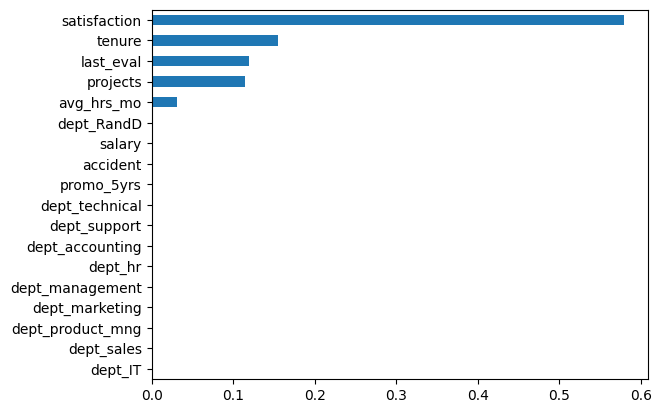

In [232]:
# Build a feature importance graph to illustrate the most important features of the decision tree
importances = tree_eval.best_estimator_.feature_importances_
forest_importance = pd.Series(importances, index=X.columns).sort_values(ascending=True)
fig, ax = plt.subplots()
forest_importance.plot.barh(ax=ax);

`Satisfaction` seems to be playing an oversized role in the model, which is unfortunate because of the subjective nature of the score. Let's be honest: we've all taken employee satifaction surveys at our respective jobs and we know that how satisfied we are in a job depends a great deal on how we're feeling at the time we take the survey, and how confident we are that we won't get in trouble for our responses. It is an important metric because it **could** be true. It is still subjective and should be treated carefully.

The other ranking features -- `tenure`, `last_eval`, `projects`, and `avg_hrs_mo` make sense. It is surprising that `salary`, `accident`, or `promo_5yrs` did not score at all. That does not mean that they have no effect on the model: it could be that they didn't have an effect in *this* model. No effect was registered for `dept_sales`, either, which has the highest number of employees and the highest turnover. Perhaps departments with little turnover and fewer employees (like `management` and `hr`, for instance) could be dropped for better results.

For now, save the results and add them to the master results table.

In [233]:
# Create results
tree_eval_results = make_results('Decision Tree Round 1 CV', tree_eval)
tree_eval_results

model_name        f1  precision    recall  accuracy   roc_auc
0  Decision Tree Round 1 CV  0.935137   0.956349  0.914964  0.978627  0.974173

In [234]:
# Update the `master_results` table
master_results=pd.concat([master_results, tree_eval_results], axis=0)
master_results.reset_index(inplace=True, drop=True)
master_results

model_name        f1  precision    recall  accuracy   roc_auc
0       Logistic Regression  0.319885   0.497758  0.235669  0.830946  0.593707
1  Decision Tree Round 1 CV  0.935137   0.956349  0.914964  0.978627  0.974173

The scores from the decision tree model are much better than those of the logistic regression. These results are strong indicators that the decision tree model will perform well. However, decision trees are highly susceptible to overfitting. In order to guard against that possibility, a random forest model, which is more resistant to overfitting by building multiple trees from which to make predictions.

### Random Forest  (Round 1)

Random Forest models have a number of hyperparameters that can be tried to find the best possible model. The `GridSearchCV` function can test a range of values for several parameters when the model is fit to the training data. There's a trade-off, though, for when multiple hyperparameters are tried, the processing cost dramatically increases. Some models can run for hours or days, even. Given that this is a case study for training purposes using artificial data, a final production-quality model is not really the goal. But we still want as good a model as we can build.

Construct a Random Forest model with cross-validation to find the best model parameters.

In [235]:
# Instantiate the model
rf1 = RandomForestClassifier(random_state=42)

# Assign the hyperparameters to test
cv_params = {'max_depth' : [3, 5, None],
             'max_features' : [1.0],
             'max_samples' : [0.7, 1.0],
             'min_samples_leaf' : [1, 2, 3],
             'min_samples_split' : [2, 3, 4],
             'n_estimators' : [300, 500]}

# Assign the scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate the gridsearch
rf1_cv = GridSearchCV(rf1, cv_params, scoring=scoring, cv=4, verbose=3, refit='roc_auc')


**Warning** The cell below contains the code to execute the process to fit the model to the training data. 

This code cell and the next one may be commented out or live, depending on when and where this notebook is being accessed. If models have already been fitted and saved to disk, the next 2 code cells should be commented out using the multi-line comment delimiter ''' (or """). This will make running all the code in the notebook run much faster (just a couple of minutes).

If this is the first time this notebook is being run and/or it is unknown if the models have been previously saved to disk, then both code cells will need to be run for the rest of the notebook to work. On the two lines ineach cell that read only `'''`,  add a `#` in front of the three quote marks `'''` so that the line reads: `#'''`. It could take 20 minutes or more for this model to be fit to the data.

In [236]:
%%time
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# Fit the model to the training data
rf1_cv.fit(X_train, y_train)
'''

CPU times: total: 0 ns
Wall time: 0 ns


'\n# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\n# Fit the model to the training data\nrf1_cv.fit(X_train, y_train)\n'

Because the model can take around 20 minutes or more to run, the next cell will save the trained model as a pickle. Activate the cell only if the code cell above was activated. Run the cell and then comment out both cells so they don't run again. This notebook will attempt to use the saved fitted model in order to save time.

In [237]:
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# Write the pickle
write_pickle(rf1_cv, 'hr_rf1')
'''

"\n# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\n# Write the pickle\nwrite_pickle(rf1_cv, 'hr_rf1')\n"

Read the saved model from disk.

In [247]:
# Read the pickle
rf1_cv = read_pickle('hr_rf1')

How did the model perform? Let's get some evaluation metrics.

In [248]:
# Check the best parameters for the model
rf1_cv.best_score_

0.9813468304416236

The best_score_ result shows the best ROC_AUC score of the best_estimator model. We'd like to be as close to 1 as possible. $0.98$ is a mighty fine score.

In [249]:
rf1_cv.best_estimator_

RandomForestClassifier(max_depth=5, max_features=1.0, max_samples=0.7,
                       min_samples_leaf=3, n_estimators=500, random_state=42)

In [241]:
rf1_cv.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

These are the best model parameters given those settings that we tested. Now we retune the model with these best parameters and re-fit the model to the training data. Let's change the random state seed so that we don't get the exact same results and run the risk of the model memorizing the training data.

> **Warning:** The cell below contains the code to execute the process to fit the model to the training data. 

> This code cell and the next one may be commented out or live, depending on when and where this notebook is being accessed. If models have already been fitted and saved to disk, the next 2 code cells should be commented out using the multi-line comment delimiter ''' (or """). 

> If this is the first time this notebook is being run and/or it is unknown if the models have been previously saved to disk, then both code cells will need to be run for the rest of the notebook to work. On the two lines ineach cell that read only `'''`,  add a `#` in front of the three quote marks `'''` so that the line reads: `#'''`. 

In [250]:
%%time
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).
# 
# Re-fit the model with the best fit parameters
rf1_eval = RandomForestClassifier(random_state=24)
cv_params = {'max_depth': [5],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf' : [3],
             'min_samples_split' : [2],
             'n_estimators': [500],
             }

# Instantiate the gridsearch
rf1_eval_cv = GridSearchCV(rf1_eval, cv_params, scoring=scoring, verbose=3, cv=4, refit='roc_auc')
rf1_eval_cv.fit(X_train, y_train)
'''


Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END max_depth=5, max_features=1.0, max_samples=0.7, min_samples_leaf=3, min_samples_split=2, n_estimators=500; accuracy: (test=0.984) f1: (test=0.951) precision: (test=0.968) recall: (test=0.935) roc_auc: (test=0.986) total time=   3.0s
[CV 2/4] END max_depth=5, max_features=1.0, max_samples=0.7, min_samples_leaf=3, min_samples_split=2, n_estimators=500; accuracy: (test=0.977) f1: (test=0.931) precision: (test=0.950) recall: (test=0.912) roc_auc: (test=0.978) total time=   3.0s
[CV 3/4] END max_depth=5, max_features=1.0, max_samples=0.7, min_samples_leaf=3, min_samples_split=2, n_estimators=500; accuracy: (test=0.980) f1: (test=0.940) precision: (test=0.964) recall: (test=0.918) roc_auc: (test=0.983) total time=   3.0s
[CV 4/4] END max_depth=5, max_features=1.0, max_samples=0.7, min_samples_leaf=3, min_samples_split=2, n_estimators=500; accuracy: (test=0.979) f1: (test=0.935) precision: (test=0.978) recall: (test=0.895

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=24),
             param_grid={'max_depth': [5], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [3],
                         'min_samples_split': [2], 'n_estimators': [500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=3)

The next cell will save the trained model as a pickle. Activate the cell only if the code cell above was activated. Run the cell and then comment out both cells so they don't run again. This notebook will attempt to use the saved fitted model in order to save time.

In [256]:
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# Write the pickle
write_pickle(rf1_eval_cv, 'hr_rf1_eval')

'''

"\n# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\n# Write the pickle\nwrite_pickle(rf1_eval_cv, 'hr_rf1_eval')\n\n"

In [257]:
# Read the pickle
rf1_eval_cv = read_pickle('hr_rf1_eval')

In [258]:
# Check the best roc_auc score
print(f"The best ROC_AUC score for Random Forest Model 1:      {rf1_cv.best_score_}")
print(f"The best ROC_AUC score for Random Forest Eval Model 1: {rf1_eval_cv.best_score_}")

The best ROC_AUC score for Random Forest Model 1:      0.9813468304416236
The best ROC_AUC score for Random Forest Eval Model 1: 0.9812731333242386


The re-tuned model performed just a hair below the performance of the best_estimator_'s best ROC_AUC score. This could be a good sign.

We'll pull the results and add them to the master results table.

In [259]:
# Collect the evaluation scores on the training set and add 
rf1_eval_cv_results = make_results('Random Forest Round 1 CV', rf1_eval_cv)
rf1_eval_cv_results

model_name        f1  precision   recall  accuracy   roc_auc
0  Random Forest Round 1 CV  0.939214   0.965035  0.91494   0.98006  0.981273

In [260]:
# Create master results table
master_results = pd.concat([master_results, rf1_eval_cv_results], axis=0)
master_results.reset_index(inplace=True, drop=True)
master_results

model_name        f1  precision    recall  accuracy   roc_auc
0       Logistic Regression  0.319885   0.497758  0.235669  0.830946  0.593707
1  Decision Tree Round 1 CV  0.935137   0.956349  0.914964  0.978627  0.974173
2  Random Forest Round 1 CV  0.939214   0.965035  0.914940  0.980060  0.981273
3  Random Forest Round 1 CV  0.939214   0.965035  0.914940  0.980060  0.981273

The results for both the decision tree and the first round random forest are quite close, and much better than those of the logistic regression. The differences in the tree-based models are very small and indicate that the decision tree model may be slightly outperforms the random forest.

### Evaluate the Models using Test Data
We should now evaluate the 2 tree-based models using the test data. The drawback to doing this is that the model will be exposed to the test data, leaving nothing with which to evaluate the champion. We'll essentially be tuning the models a bit more.

Get the results and add them to the master results table.

In [263]:
# Get the evaluation results for the test set from the Decision Tree 'final' model
dt_test_scores = get_test_scores('Decision Tree Round 1 Test', tree_eval, X_test, y_test)
dt_test_scores

model_name        f1  precision    recall  accuracy  \
0  Decision Tree Round 1 Test  0.933624   0.957589  0.910828  0.978152   

    roc_auc  
0  0.951321

In [264]:
# Get the evaluation results for the test set from the Random Forest 'final' model
rf1_test_scores = get_test_scores('Random Forest Round 1 Test', rf1_eval_cv, X_test, y_test)
rf1_test_scores

model_name        f1  precision    recall  accuracy  \
0  Random Forest Round 1 Test  0.941304   0.964365  0.919321  0.980659   

    roc_auc  
0  0.956214

In [265]:
# Add the new results to the master table
master_results = pd.concat([master_results, dt_test_scores, rf1_test_scores], axis=0)
master_results.reset_index(inplace=True, drop=True)
master_results

model_name        f1  precision    recall  accuracy  \
0         Logistic Regression  0.319885   0.497758  0.235669  0.830946   
1    Decision Tree Round 1 CV  0.935137   0.956349  0.914964  0.978627   
2    Random Forest Round 1 CV  0.939214   0.965035  0.914940  0.980060   
3  Decision Tree Round 1 Test  0.933624   0.957589  0.910828  0.978152   
4  Random Forest Round 1 Test  0.941304   0.964365  0.919321  0.980659   

    roc_auc  
0  0.593707  
1  0.974173  
2  0.981273  
3  0.951321  
4  0.956214

If we assume `ROC_AUC` to be the heaviest weighted result, then the training evaluation Random Forest model performed the best at about $0.98$. The test evaluation Random Forest performed better than the test evaluation Decision Tree model, but both underperformed the training evaluation Decision Tree model. 

That being said, `Precision` (the percentage of correct predictions out of all T/F positive predictions), `Recall` (the percentage of correct predictions out of all actual positives), and `F1` (the harmonic mean between `Recall` and `Precision`) scores provide additional insight. The test evalution of the Random Forest model ranked higher in these three metrics than did the either evaluation of the Decision Tree model, and slightly better overall than the training evaluation of itself.

All in all, the Random Forest model has performed better. But there could be a lot of noise in the models.

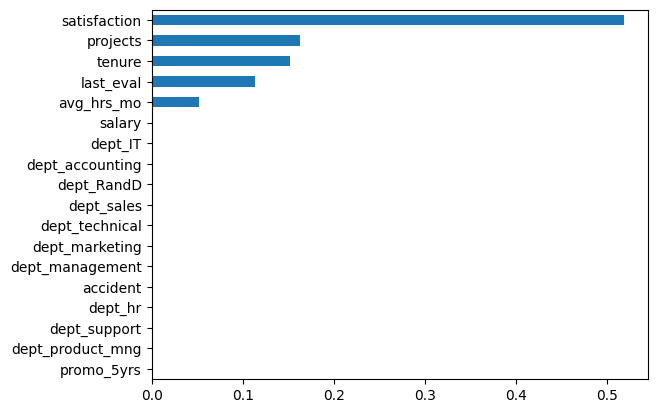

In [267]:
# Build a feature importance graph to illustrate the most important features of the Random Forest
importances = rf1_eval_cv.best_estimator_.feature_importances_
forest_importance = pd.Series(importances, index=X.columns).sort_values(ascending=True)
fig, ax = plt.subplots()
forest_importance.plot.barh(ax=ax);

As well as both of the tree-based models performed, there could be some data leakage. Data leakage occurs when training data appears in the test data, or when features appear in the model that may not be available once the model is deployed.

We are attempting to predict whether an employee will leave or stay. Features that don't consistently help with that should not be in the model. As mentioned, as a self-reported feature, `satisfaction` is an unreliable subjective datapoint and should be dropped. Further, satisfaction scores are usually collected once, maybe twice each year, and 100% participation is very hard to achieve. It's likely that at any point in time when the model is used in production, there will not be recent satisfaction scores for every employee. 

Another feature to consider is `avg_hrs_mo`, which may be problematic because workers who have already decided to leave may work fewer hours, while others may skate along with no intention of rocking any boats. Applying feature engineering, we can create a new feature, `overworked` derived from `avg_hrs_mo`. Assuming 166.67 average working hours per month, we could say that an employee working more than 175 hours (essentially an additional day per month) is overworked. 

After a little more feature engineering, we'll run the tree-based models again.

## Feature Engineering for Round 2

For this round, let's refine the dataset a little bit. We'll first remove `satisfaction` and then we'll 

In [270]:
# Drop the `satisfaction` feature
df2=df_encoded.copy().drop('satisfaction', axis=1)
df2.head()

last_eval  projects  avg_hrs_mo  tenure  accident  termed  promo_5yrs  \
0       0.53         2         157       3         0       1           0   
1       0.86         5         262       6         0       1           0   
2       0.88         7         272       4         0       1           0   
3       0.87         5         223       5         0       1           0   
4       0.52         2         159       3         0       1           0   

   salary  dept_IT  dept_RandD  dept_accounting  dept_hr  dept_management  \
0       0    False       False            False    False            False   
1       1    False       False            False    False            False   
2       1    False       False            False    False            False   
3       0    False       False            False    False            False   
4       0    False       False            False    False            False   

   dept_marketing  dept_product_mng  dept_sales  dept_support  dept_technical  
0           False             False        True         False           False  
1           False             False        True         False           False  
2           False             False        True         False           False  
3           False             False        True         False           False  
4           False             False        True         False           False

In [272]:
# Create the `overworked` feature, for now as a copy of `avg_hrs_mo`.
df2['overworked'] = df2['avg_hrs_mo']
# df2['underworked'] = df2['avg_hrs_mo']

# Get the min & max number of average hours worked
print(f"Max hours per month: {df2['overworked'].max()}")
print(f"Min hours per month: {df2['overworked'].min()}")

Max hours per month: 310
Min hours per month: 96


Now, turn `overworked` into a binary by applying a boolean mask. 

In [273]:
# Define the overworked feature
df2['overworked'] = (df2['overworked'] > 175).astype(int)

# Define the underworked feature
# df2['underworked'] = (df2['underworked'] < 158).astype(int)


Now, drop the `avg_hrs_mo` feature.

In [274]:
# Drop avg hrs
df2 = df2.drop('avg_hrs_mo', axis=1)
df2.head()

last_eval  projects  tenure  accident  termed  promo_5yrs  salary  dept_IT  \
0       0.53         2       3         0       1           0       0    False   
1       0.86         5       6         0       1           0       1    False   
2       0.88         7       4         0       1           0       1    False   
3       0.87         5       5         0       1           0       0    False   
4       0.52         2       3         0       1           0       0    False   

   dept_RandD  dept_accounting  dept_hr  dept_management  dept_marketing  \
0       False            False    False            False           False   
1       False            False    False            False           False   
2       False            False    False            False           False   
3       False            False    False            False           False   
4       False            False    False            False           False   

   dept_product_mng  dept_sales  dept_support  dept_technical  overworked  
0             False        True         False           False           0  
1             False        True         False           False           1  
2             False        True         False           False           1  
3             False        True         False           False           1  
4             False        True         False           False           0

Ok, that looks clean. We can isolate the y-target and the X-predictors.

In [275]:
# Isolate the y-target variable
y = df2['termed']

# Select the features
X = df2.copy().drop('termed', axis=1)

In [276]:
X.columns

Index(['last_eval', 'projects', 'tenure', 'accident', 'promo_5yrs', 'salary',
       'dept_IT', 'dept_RandD', 'dept_accounting', 'dept_hr',
       'dept_management', 'dept_marketing', 'dept_product_mng', 'dept_sales',
       'dept_support', 'dept_technical', 'overworked'],
      dtype='object')

Split the newly engineered data into training and test sets.

In [277]:
# Split the new dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=8675309)

### Decision Tree (Round 2)

Instantiate a new Decision Tree model with a new `random_state` seed value. We'll follow the same steps as previously, just with a slightly tweaked dataset.

In [104]:
# Instantiate model
tree_r2 = DecisionTreeClassifier(random_state=8675309)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree_r2_cv = GridSearchCV(tree_r2, cv_params, scoring=scoring, verbose=3, cv=4, refit='roc_auc')

> **Warning:** The cell below contains the code to execute the process to fit the model to the training data. 

> This code cell and the next one may be commented out or live, depending on when and where this notebook is being accessed. If models have already been fitted and saved to disk, the next 2 code cells should be commented out using the multi-line comment delimiter ''' (or """). 

> If this is the first time this notebook is being run and/or it is unknown if the models have been previously saved to disk, then both code cells will need to be run for the rest of the notebook to work. On the two lines ineach cell that read only `'''`,  add a `#` in front of the three quote marks `'''` so that the line reads: `#'''`. 

In [278]:
%%time
'''
# This cell can be commented if the model has been saved to disk as a pickle. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# Fit the model
tree_r2_cv.fit(X_train, y_train)
'''

CPU times: total: 0 ns
Wall time: 0 ns


'\n# This cell can be commented if the model has been saved to disk as a pickle. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\n# Fit the model\ntree_r2_cv.fit(X_train, y_train)\n'

The next cell will save the trained model as a pickle. Activate the cell only if the code cell above was activated. Run the cell and then comment out both cells so they don't run again. This notebook will attempt to use the saved fitted model in order to save time.

In [279]:
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# Write the pickle
write_pickle(tree_r2_cv, 'hr_tree_r2_cv')
'''

"\n# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\n# Write the pickle\nwrite_pickle(tree_r2_cv, 'hr_tree_r2_cv')\n"

In [280]:
# Read the pickle
tree_r2_cv = read_pickle('hr_tree_r2_cv')

In [281]:
# Check the best parameters
tree_r2_cv.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}

In [282]:
tree_r2_cv.best_score_

0.955919003789671

The model appears to perform very well, but we'll train the model with the evaluation parameters and retrieve the evaluation metrics.

In [284]:
# Instantiate model
tree_r2_eval = DecisionTreeClassifier(random_state=1313)
cv_params = {'max_depth': [6],
             'min_samples_leaf': [1],
             'min_samples_split': [6]}

tree_r2_eval_cv = GridSearchCV(tree_r2_eval, cv_params, scoring=scoring, verbose=1, cv=4, refit='roc_auc')

In [285]:
%%time
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# fit the best params model to the data
tree_r2_eval_cv.fit(X_train, y_train)
'''

Fitting 4 folds for each of 1 candidates, totalling 4 fits
CPU times: total: 93.8 ms
Wall time: 98.7 ms


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=1313),
             param_grid={'max_depth': [6], 'min_samples_leaf': [1],
                         'min_samples_split': [6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [288]:
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# Write the pickle
write_pickle(tree_r2_eval_cv, 'hr_tree_r2_eval_cv')
'''

"\n# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\n# Write the pickle\nwrite_pickle(tree_r2_eval_cv, 'hr_tree_r2_eval_cv')\n"

In [287]:
# Read the pickle
tree_r2_eval_cv = read_pickle('hr_tree_r2_eval_cv')

In [289]:
# Get all of the CV results
tree_r2_eval_cv_results = make_results('Decision Tree Round 2 CV', tree_r2_eval_cv)
tree_r2_eval_cv_results

model_name        f1  precision    recall  accuracy   roc_auc
0  Decision Tree Round 2 CV  0.864116   0.836856  0.894831  0.952962  0.955831

In [290]:
# Add the round 2 decision tree results to the master results table
master_results = pd.concat([master_results, tree_r2_eval_cv_results], axis=0)
master_results.reset_index(inplace=True, drop=True)
master_results

model_name        f1  precision    recall  accuracy  \
0         Logistic Regression  0.319885   0.497758  0.235669  0.830946   
1    Decision Tree Round 1 CV  0.935137   0.956349  0.914964  0.978627   
2    Random Forest Round 1 CV  0.939214   0.965035  0.914940  0.980060   
3  Decision Tree Round 1 Test  0.933624   0.957589  0.910828  0.978152   
4  Random Forest Round 1 Test  0.941304   0.964365  0.919321  0.980659   
5    Decision Tree Round 2 CV  0.864116   0.836856  0.894831  0.952962   

    roc_auc  
0  0.593707  
1  0.974173  
2  0.981273  
3  0.951321  
4  0.956214  
5  0.955831

The results of round 2 were not as good as the first round. There are fewer features in the 2nd round models, so that could well account for the difference. As it is, the model does still perform strongly, even if the other metrics fell a little more than expected.

### Random Forest (Round 2)

Now we'll build a forest using the re-engineered dataset. Same process as before.

In [302]:
# Instantiate model
rf2 = RandomForestClassifier(random_state=1701)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf2_cv = GridSearchCV(rf2, cv_params, scoring=scoring, verbose=1, cv=4, refit='roc_auc')

In [303]:
%%time
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

rf2_cv.fit(X_train, y_train)
all_done()
'''

CPU times: total: 0 ns
Wall time: 0 ns


'\n# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\nrf2_cv.fit(X_train, y_train)\nall_done()\n'

In [304]:
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# Write the pickle
write_pickle(rf2_cv, 'hr_rf2_cv')
'''

"\n# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\n# Write the pickle\nwrite_pickle(rf2_cv, 'hr_rf2_cv')\n"

In [305]:
# Read the pickle
rf2_cv = read_pickle('hr_rf2_cv')

In [306]:
# Check best AUC score on CV
rf2_cv.best_score_

0.9664284406914119

In [307]:
# Check best params
rf2_cv.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [308]:
# Instantiate the best-fit model
rf2_eval = RandomForestClassifier(random_state=1701)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [5], 
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [3],
             'min_samples_split': [2],
             'n_estimators': [500]}  

# Instantiate GridSearch
rf2_eval_cv = GridSearchCV(rf2_eval, cv_params, scoring=scoring, verbose=3, cv=4, refit='roc_auc')

In [309]:
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# Fit the best parameters model to the data
rf2_eval_cv.fit(X_train, y_train)
'''

'\n# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\n# Fit the best parameters model to the data\nrf2_eval_cv.fit(X_train, y_train)\n'

In [310]:
'''
# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  
#  1st and last rows to stop this cell from running (turn on multi-line comments).

# Write the pickle
write_pickle(rf2_eval_cv, 'hr_rf2_eval_cv')
'''

"\n# This code cell may be commented out if the pickle file has already been saved. Remove the comment # on the  \n#  1st and last rows to stop this cell from running (turn on multi-line comments).\n\n# Write the pickle\nwrite_pickle(rf2_eval_cv, 'hr_rf2_eval_cv')\n"

In [311]:
# Read the pickle
rf2_eval_cv = read_pickle('hr_rf2_eval_cv')

In [300]:
# Get the best params scores
rf2_results = make_results('Random Forest Round 2 CV', rf2_eval_cv)
rf2_results

model_name        f1  precision    recall  accuracy   roc_auc
0  Random Forest Round 2 CV  0.883109   0.866243  0.900858  0.960414  0.966428

In [301]:
# Add these results to the master results table
master_results = pd.concat([master_results, rf2_results], axis=0)
master_results.reset_index(inplace=True, drop=True)
master_results

model_name        f1  precision    recall  accuracy  \
0         Logistic Regression  0.319885   0.497758  0.235669  0.830946   
1    Decision Tree Round 1 CV  0.935137   0.956349  0.914964  0.978627   
2    Random Forest Round 1 CV  0.939214   0.965035  0.914940  0.980060   
3  Decision Tree Round 1 Test  0.933624   0.957589  0.910828  0.978152   
4  Random Forest Round 1 Test  0.941304   0.964365  0.919321  0.980659   
5    Decision Tree Round 2 CV  0.864116   0.836856  0.894831  0.952962   
6    Random Forest Round 2 CV  0.883109   0.866243  0.900858  0.960414   

    roc_auc  
0  0.593707  
1  0.974173  
2  0.981273  
3  0.951321  
4  0.956214  
5  0.955831  
6  0.966428

Again, the scores varied slightly from the previous random forest. In round 2, going by the roc_auc score, the Random Forest model performs slightly better than the Decision Tree model. We'll get the test data results for both models.

In [312]:
rf2_test_scores = get_test_scores('Random Forest Round 2 Test', rf2_eval_cv, X_test, y_test)
rf2_test_scores

model_name        f1  precision    recall  accuracy  \
0  Random Forest Round 2 Test  0.893744   0.884086  0.903614   0.96431   

    roc_auc  
0  0.940007

In [313]:
tree_r2_test_scores = get_test_scores('Decision Tree Round 2 Test', tree_r2_eval_cv, X_test, y_test)
tree_r2_test_scores

model_name        f1  precision    recall  accuracy  \
0  Decision Tree Round 2 Test  0.848934   0.788296  0.919679   0.94563   

    roc_auc  
0  0.935239

In [314]:
# Update the master results table
master_results = pd.concat([master_results, tree_r2_test_scores, rf2_test_scores], axis=0)
master_results.reset_index(inplace=True, drop=True)
master_results

model_name        f1  precision    recall  accuracy  \
0         Logistic Regression  0.319885   0.497758  0.235669  0.830946   
1    Decision Tree Round 1 CV  0.935137   0.956349  0.914964  0.978627   
2    Random Forest Round 1 CV  0.939214   0.965035  0.914940  0.980060   
3  Decision Tree Round 1 Test  0.933624   0.957589  0.910828  0.978152   
4  Random Forest Round 1 Test  0.941304   0.964365  0.919321  0.980659   
5    Decision Tree Round 2 CV  0.864116   0.836856  0.894831  0.952962   
6    Random Forest Round 2 CV  0.883109   0.866243  0.900858  0.960414   
7  Decision Tree Round 2 Test  0.848934   0.788296  0.919679  0.945630   
8  Random Forest Round 2 Test  0.893744   0.884086  0.903614  0.964310   

    roc_auc  
0  0.593707  
1  0.974173  
2  0.981273  
3  0.951321  
4  0.956214  
5  0.955831  
6  0.966428  
7  0.935239  
8  0.940007

Plot a confusion matrix to check the models.

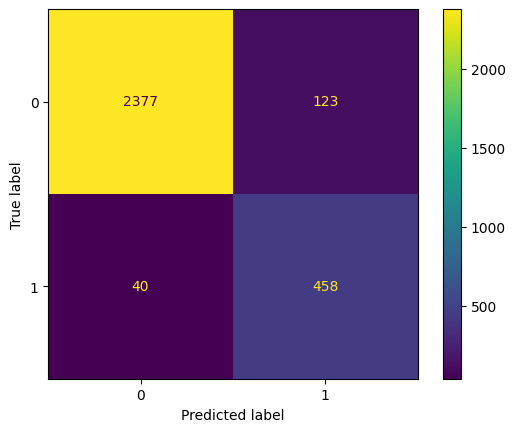

In [315]:
# Generate array of values for Random Forest confusion matrix
tree_r2_preds = tree_r2_eval_cv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, tree_r2_preds, labels=tree_r2_eval_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=tree_r2_eval_cv.classes_)
disp.plot(values_format='');

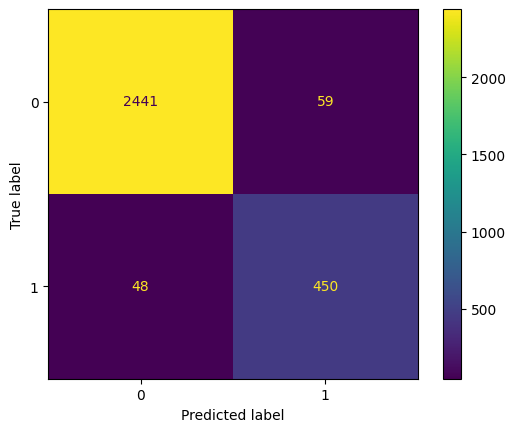

In [316]:
# Generate array of values for Random Forest confusion matrix
rf_preds = rf2_eval_cv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, rf_preds, labels=rf2_eval_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2_eval_cv.classes_)
disp.plot(values_format='');

Both the Decision Tree and the Random Forest modified models had the same predictions: about 1.8x the number of false positives (predicted to leave but stayed) were identified

### Decision Tree Splits

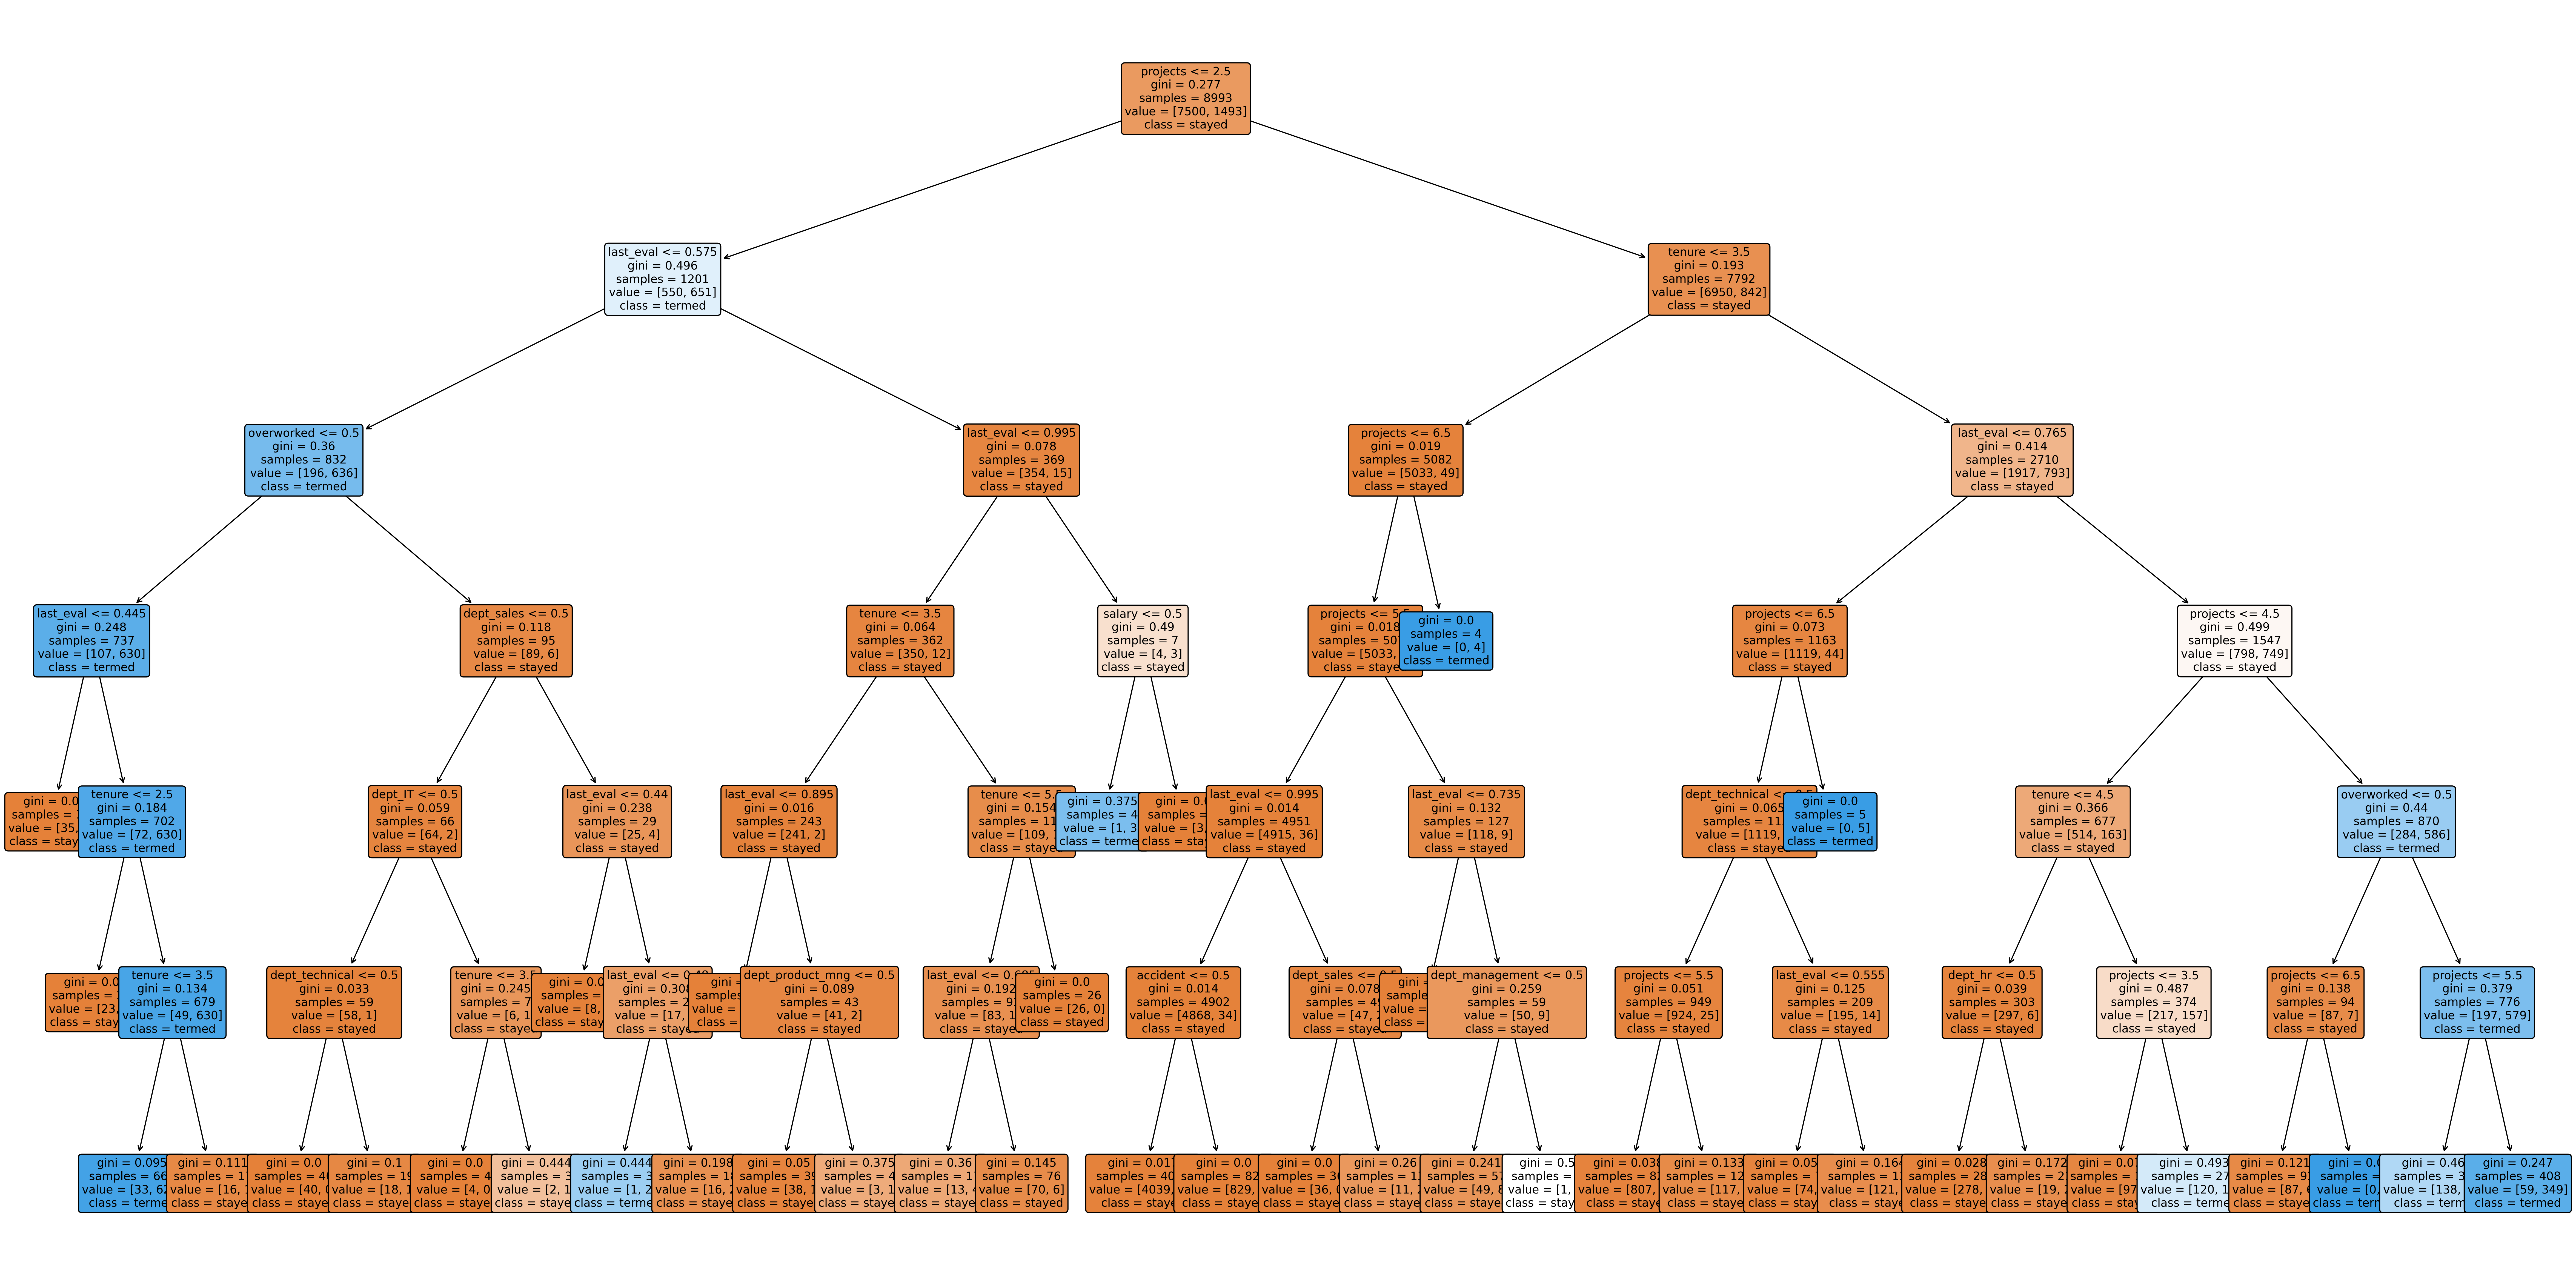

In [318]:
## Set figure and axes
plt.figure(figsize=(40,20), dpi=300)

plot_tree(tree_r2_eval_cv.best_estimator_, feature_names=(list(X.columns)), 
          class_names=(['stayed', 'termed']), rounded=True, fontsize=10, filled=True);
plt.show()

The decision tree may be a bit overfit. It appears that a number of additional features could be dropped. If there's ever a Round 3...

### Decision Tree Feature Importance

In [137]:
# tree3_eval_cv_importances = pd.DataFrame(tree3_eval_cv.best_estimator_.feature_importances_, columns=X.columns)
tree_r2_eval_cv_importances = pd.DataFrame(tree_r2_eval_cv.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree_r2_eval_cv_importances = tree_r2_eval_cv_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree_r2_eval_cv_importances = tree_r2_eval_cv_importances[tree_r2_eval_cv_importances['gini_importance'] != 0]
tree_r2_eval_cv_importances

gini_importance
projects                 0.342457
last_eval                0.329863
tenure                   0.224196
overworked               0.100757
salary                   0.001073
dept_sales               0.000511
dept_technical           0.000354
dept_management          0.000278
dept_product_mng         0.000203
dept_hr                  0.000143
dept_IT                  0.000110
accident                 0.000053

There are a lot of features that *appear* to have little to no effect on the model. In a possible Round 3, perhaps we drop `accident`, `dept_IT`, `dept_hr` and then see how well the model fares.

Display these results on a bar chart.

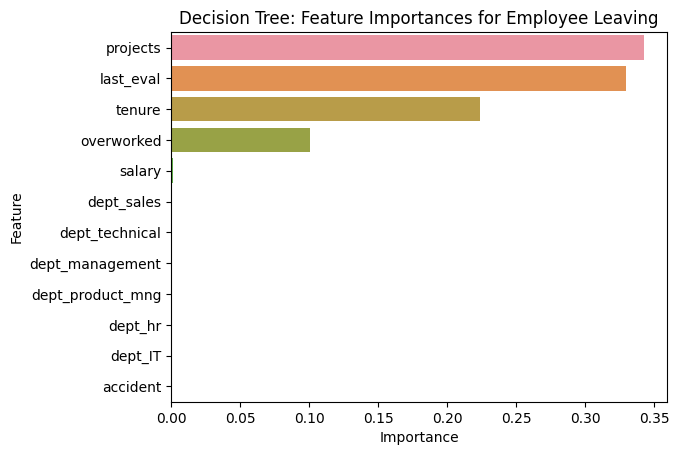

In [319]:
sns.barplot(data=tree_r2_eval_cv_importances, x="gini_importance", y=tree_r2_eval_cv_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

This is pretty interesting. An earlier iteration that included an `underworked` boolean feature that would be true if the employee worked less than 158 hours produced an outcome where `underworked` placed on this importance graph, but `overworked` did not. Also surprising is to see `salary` having such little impact. Apparently, working in either Technical or Sales departments indicated a higher propensity to leave than other departments. 

### Random Forest Feature Importance

Now, do the same with the Random Forest model.

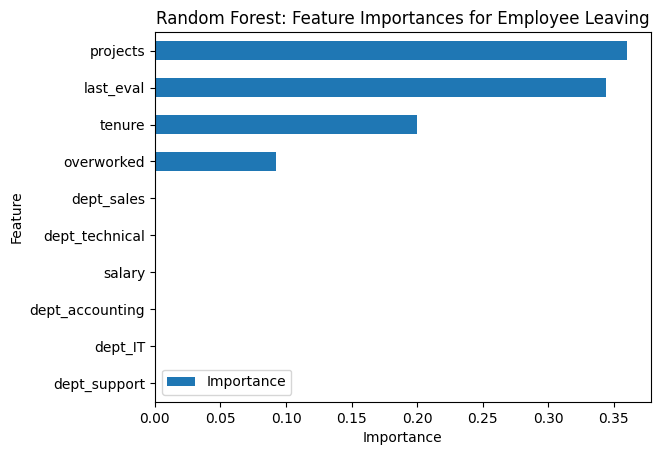

In [320]:
# Get feature importances
feat_impt = rf2_eval_cv.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2_eval_cv.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

Virtually identical results in the Random Forest champion as with the Decision Tree champion, but that is rather to be expected as the scores were so remarkably similar.

In [140]:
master_results

model_name        f1  precision    recall  accuracy  \
0         Logistic Regression  0.319885   0.497758  0.235669  0.830946   
1    Decision Tree Round 1 CV  0.935137   0.956349  0.914964  0.978627   
2    Random Forest Round 1 CV  0.939214   0.965035  0.914940  0.980060   
3  Decision Tree Round 1 Test  0.933624   0.957589  0.910828  0.978152   
4  Random Forest Round 1 Test  0.942329   0.966518  0.919321  0.981017   
5    Decision Tree Round 2 CV  0.864387   0.837364  0.894831  0.953073   
6    Random Forest Round 2 CV  0.872407   0.866758  0.878754  0.957411   
7  Decision Tree Round 2 Test  0.848934   0.788296  0.919679  0.945630   
8  Random Forest Round 2 Test  0.899800   0.898000  0.901606  0.966644   

    roc_auc  
0  0.593707  
1  0.974173  
2  0.981347  
3  0.951321  
4  0.956429  
5  0.955919  
6  0.964810  
7  0.935239  
8  0.940603

## Step 4. Results and Evaluation
- Interpret model
- Evaluate model performance using metrics
- Prepare results, visualizations, and actionable steps to share with stakeholders




### Summary of model results

#### Logistic Regression
The logistic regression model performed more poorly than any of the other models. The model achieved a precision score of 44%, a recall score of 26%, and an F1 score of ~33% (weighted averages), and an accuracy score of ~82%. The AUC score was ~59.7%.

#### Tree-Based Models
In the final feature engineered models, the random forest model performed better on the test data than did the decision tree model. The random forest had results that were 4.61% better on F1 score, 8.57% better on precision, 1.87% on accuracy, and 1.04% on AUC. The decision tree model performed 0.2% better on the recall score than did the random forest.

### Conclusion, Recommendations, Next Steps

The model results and the feature importances extracted from the models indicate that employees here are overworked. Some recommendations:

- Place a limit on the number of projects employees are asked to work on. More than 5 projects per month is not sustainable over the long haul.
- Consider policy changes to allow for more frequent promotions, and off-cycle promotions in reward for merit. 
- Employees working excessive hours should be properly rewarded and praised. Employees not pulling their weight should not be rewarded or promoted simply for putting in 5 years.
- Investigate the company culture. There are indications of some disequity and unfairness. 
- Consider additional protocols around the employee satisfaction survey. Ensure anonymity and encourage honest responses. This needs to start from the top down under the color of, "We know something's not right and we want to fix it. Tell us what you see."

#### Next Steps
It may be justified to still have some concern about data leakage. It could be prudent to consider how predictions change when `last_eval` is removed from the data. It's possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature. It's also possible that the evaluation score determines whether an employee leaves or stays, in which case it could be useful to pivot and try to predict performance score. The same could be said for satisfaction score. 

For another project, you could try building a K-means model on this data and analyzing the clusters. This may yield valuable insight. 

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.